# 1. Introduction

The application of machine learning in healthcare is crucial, especially for tasks such as predicting hospital readmission for diabetic patients. This project uses a dataset of 101,766 hospital visits to classify readmissions into three categories, emphasizing the urgency of predicting readmission within 30 days. By employing techniques such as data imputation, resampling, and feature reduction, the XGBoost model with Random Undersampling is identified as the optimal approach for accurate predictions.

# 2. Data Import


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
import warnings
import seaborn as sns
import numpy as np
import time
import optuna
import joblib

from sklearn.model_selection import learning_curve, cross_val_score, cross_val_predict, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, make_scorer
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression, LassoCV, LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_selection import RFE

from scipy.stats import chi2_contingency


warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.ERROR)


In [190]:
# Load in the training and testing datasets
train_path = os.path.join("Dataset", "diabetic_data_training.csv")
test_path = os.path.join("Dataset", "diabetic_data_test.csv")
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

## 3. Data Transformation & Exploration


## Function Definitions

In [191]:
def barplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, topn=None, ax=None):
    """
    Draw barplot of attribute per each class.
    
    :param df: dataframe with data to be drawn on barplot.
    :param attribute: name of attribute to be drawn on barplot.
    :param groupby: name of attribute with predicted classes.
    :param title: title of plot.
    :param ticks_rotation: rotation of x-ticks (labels).
    :param topn: top n classes to be drawn on the plot.
    :param ax: matplotlib Axes object to draw the plot onto.
    """
    uniq_values = df[attribute].value_counts().head(topn).index
    df = df[df[attribute].isin(uniq_values)]
    data = df.groupby(groupby)[attribute].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
    sns.barplot(x=attribute, y='percentage', hue=groupby, data=data, ax=ax, palette='tab10')
    plt.xticks(rotation=ticks_rotation)
    plt.title(title)

def kdeplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, ax=None):
    """
    Draw kdeplot of attribute per each class.
    
    :param df: dataframe with data to be drawn on kdeplot.
    :param attribute: name of attribute to be drawn on kdeplot.
    :param groupby: name of attribute with predicted classes.
    :param title: title of plot.
    :param ticks_rotation: rotation of x-ticks (labels).
    :param ax: matplotlib Axes object to draw the plot onto.
    """
    for x in df[groupby].unique():
        sns.kdeplot(df[df[groupby] == x][attribute], label=x, shade=True, shade_lowest=False, ax=ax)
    plt.title(title)
    plt.xticks(rotation=ticks_rotation)

def kdeplot_multi_classes(df, attributes, groupby, title=None, ticks_rotation=0):
    """
    Draw kdeplots for a list of attributes per each class and display them in a grid.
    
    :param df: dataframe with data to be drawn on kdeplot.
    :param attributes: list of attribute names to be drawn on kdeplot.
    :param groupby: name of attribute with predicted classes.
    :param title: overall title of the plot grid.
    :param ticks_rotation: rotation of x-ticks (labels).
    """
    num_attributes = len(attributes)
    num_cols = 4  
    num_rows = (num_attributes + num_cols - 1) // num_cols  

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows), sharey=True)

    # Flatten axes for easy indexing (if there's only one row, axes won't be a 2D array)
    axes = axes.flatten()

    for i, attribute in enumerate(attributes):
        ax = axes[i]
        for x in df[groupby].unique():
            sns.kdeplot(df[df[groupby] == x][attribute], label=x, shade=True, ax=ax)
        ax.set_title(f"KDE of {attribute}")
        ax.set_xlabel(attribute)
        ax.set_ylabel("Density")
        ax.legend(title=groupby)
        ax.tick_params(axis='x', rotation=ticks_rotation)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    # Set overall title
    if title:
        plt.suptitle(title, fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the overall title
    plt.show()

def boxplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, ax=None):
    """
    Draw boxplot of attribute per each class.
    
    :param df: dataframe with data to be drawn on boxplot.
    :param attribute: name of attribute to be drawn on boxplot.
    :param groupby: name of attribute with predicted classes.
    :param title: title of plot.
    :param ticks_rotation: rotation of x-ticks (labels).
    :param ax: matplotlib Axes object to draw the plot onto.
    """
    sns.boxplot(x=groupby, y=attribute, data=df, ax=ax)
    plt.title(title)
    plt.xticks(rotation=ticks_rotation)
    
def plot_multiclass_roc(X_test, y_test, classes, classifier, title='ROC Curve for Multi-Class (One-vs-Rest)', figsize=(10, 6)):
    """
    plot AUROC curve
    """
    y_score = classifier.predict_proba(X_test)
    # convert to binary labels
    y_test_binarized = label_binarize(y_test, classes=classes)
    n_classes = len(classes)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # calculate ROC curve and auc
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting
    plt.figure(figsize=figsize)
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
    
    # plot random guess line 00 - 11
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()
    return roc_auc

def evaluate_model(model, x, y):
    """
    Evaluate the model and separately plot confusion matrix and ROC curve.

    :param model: Trained model.
    :param x: Test features.
    :param y: Test labels.
    """
    y_pred = model.predict(x)
    y_pred_prob = model.predict_proba(x)
    # Print classification report
    #print(classification_report(y, y_pred))
    # Compute Metrics
    f1 = f1_score(y, y_pred, average="macro")
    precision = precision_score(y, y_pred, average="macro")
    rs = recall_score(y, y_pred, average="macro")
    # recall_std_dev = np.std(recalls)
    # recall_score_component = recalls.mean() - recall_std_dev
    # ROC AUC
    n_classes = len(np.unique(y))
    # y_train_binarized = label_binarize(y, classes=range(n_classes))
    # rac = roc_auc_score(y_train_binarized, y_pred_prob, average="macro", multi_class="ovr")
    # PR AUC (Precision-Recall AUC for each class)
    pr_auc_scores = []
    for i in range(n_classes):
        y_true_binary = (y == i).astype(int)
        precision, recall, _ = precision_recall_curve(y_true_binary, y_pred_prob[:, i])
        pr_auc = auc(recall, precision)
        pr_auc_scores.append(pr_auc)
    pr_auc_macro = np.mean(pr_auc_scores)
    score = (f1 + rs + pr_auc_macro) / 3
    metrics = {
    'Metric': ['F1 Score Macro', 'Recall Macro', 'PRAUC', 'Final Score'],
    'Value': [f1, rs, pr_auc_macro, score]
        }
    res = pd.DataFrame(metrics)
    print(res)

    # Plot confusion matrix
    fig1, ax1 = plt.subplots(figsize=(6, 6))
    cm = confusion_matrix(y, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=ax1)
    ax1.set_title('Confusion Matrix')
    plt.show()  # Show confusion matrix in its own figure

    # Plot ROC curve
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    roc_auc(y_pred_prob, y, ax=ax2)
    ax2.set_title('ROC Curve')
    plt.show()  # Show ROC curve in its own figure

def roc_auc(y_pred_prob, y_true, plot=True, ax=None):
    """
    Draw ROC curve plot for both binary and multiclass classification.

    :param y_pred_prob: Probabilities of predicted labels.
    :param y_true: True labels.
    :param plot: If True, ROC curve plot is drawn.
    :param ax: Optional axis for plot.
    :return: Dictionary containing AUC scores for each class and macro-average AUC (for multiclass).
    """
    # Check if it's binary or multiclass
    if len(y_pred_prob.shape) == 1:  # Binary classification (1D array)
        y_pred_prob = np.vstack([1 - y_pred_prob, y_pred_prob]).T
    
    n_classes = y_pred_prob.shape[1]
    y_true_binarized = label_binarize(y_true, classes=range(n_classes))

    # Store AUC scores for each class
    auc_scores = {}

    # Compute macro-average ROC
    fpr_macro = np.linspace(0, 1, 100)
    tpr_macro = np.zeros_like(fpr_macro)

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
        auc_value = auc(fpr, tpr)
        auc_scores[f'class_{i}'] = auc_value
        tpr_macro += np.interp(fpr_macro, fpr, tpr)

    # Normalize TPR for macro-average
    tpr_macro /= n_classes
    auc_scores['macro'] = auc(fpr_macro, tpr_macro)

    # Plot ROC curves
    if plot:
        if not ax:
            fig, ax = plt.subplots(figsize=(8, 6))

        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
            ax.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {auc_scores[f"class_{i}"]:.3f})')

        # Plot macro-average ROC
        ax.plot(fpr_macro, tpr_macro, linestyle='--', linewidth=3, label=f'Macro-average (AUC = {auc_scores["macro"]:.3f})', color='red')

        ax.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curve (Binary/Multiclass)')
        ax.legend(loc="lower right")

    return auc_scores

def plot_learning_curve(
        estimator, title, X, y, cv=None, train_sizes=np.linspace(.1, 1.0, 10)
):
    """
    Plot learning curve of classifier.
    :param estimator: classifier of which learning curve will be drawn.
    :param title: title of learning curve plot.
    :param X: training data features.
    :param y: training data labels.
    :param cv: cross-validation (estimator or number of folds).
    :param train_sizes: train splits sizes.
    :return:
    """
    plt.figure()
    plt.title(title)
    plt.ylim(0.45, 1.01)
    plt.xlabel('Number of samples', labelpad=20)
    plt.ylabel('Score', labelpad=20)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label='Train score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label='Cross-validation score')

    plt.legend(loc='best')
    plt.show()

def get_cv_pipeline(model_name="qda", n_components=24):
    if model_name == "qda":
        clf = QDA()
    elif model_name == "lda":
        clf = LDA()
    elif model_name == "logistic_regression":
        clf = LogisticRegression(
            multi_class='multinomial',
            solver='lbfgs',
            max_iter=1000,
            random_state=42
        )
    elif model_name == "random_forest":
        clf = RandomForestClassifier(
            n_estimators=100,
            max_depth=30,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42
        )
    else:
        raise ValueError(f"Unknown model_name: {model_name}")
    
    # Build the combined pipeline
    pipeline = Pipeline([
        #('preprocessing', preprocess_pipeline),  # your custom transformations
        ('scaler', StandardScaler()),            # standard scaling
        ('pca', PCA(n_components=n_components)), # PCA with desired number of components
        ('classifier', clf)                      # final classifier
    ])

    return pipeline

def sampling(X_train, y_train, methods=None):
    result = {}
    if "no" in methods:
        result["no"] = (X_train, y_train)
    if "gmm" in methods:
        mask0 = y_train == 0
        mask1 = y_train == 1
        mask2 = y_train == 2

        X_filtered_0 = X_train[mask0]
        X_filtered_1 = X_train[mask1]
        X_filtered_2 = X_train[mask2]
        #Generate new data with label 1
        gmm = GaussianMixture(n_components=3, random_state=42)
        gmm.fit(X_filtered_0)
        n_samples_0 = X_filtered_2.shape[0] - X_filtered_0.shape[0]
        X_generated_0, _ = gmm.sample(n_samples=n_samples_0)
        y_generated_0 = np.full(n_samples_0, 0)

        #Generate new data with label 2
        gmm = GaussianMixture(n_components=3, random_state=42)
        gmm.fit(X_filtered_1)
        n_samples_1 = X_filtered_2.shape[0] - X_filtered_1.shape[0]
        X_generated_1, _ = gmm.sample(n_samples=n_samples_1)
        y_generated_1 = np.full(n_samples_1, 1)

        # Merge generated data and original data together
        X_balanced_gmm = np.vstack((X_train, X_generated_0, X_generated_1))
        y_balanced_gmm = np.hstack((y_train, y_generated_0, y_generated_1))
        result["gmm"] = (X_balanced_gmm, y_balanced_gmm)
    if "smote" in methods:
        count_target = np.sum(y_train == 2)
        smote = SMOTE(sampling_strategy={0:count_target, 1:count_target}, random_state=42)
        X_balanced_smt, y_balanced_smt = smote.fit_resample(X_train, y_train)
        result["smote"] = (X_balanced_smt, y_balanced_smt)
    if "undersampling" in methods:
        # Random Unsampling
        rus = RandomUnderSampler(random_state=42) 
        X_balanced_under, y_balanced_under = rus.fit_resample(X_train, y_train)
        result["undersampling"] = (X_balanced_under, y_balanced_under)
    if "stk" in methods:
        smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=42)
        X_balanced_stk, y_balanced_stk = smote_tomek.fit_resample(X_train, y_train)
        result["stk"] = (X_balanced_stk, y_balanced_stk)
    return result

def score(data, X_test, y_test, methods, classifier):
    name = str(classifier.__class__.__name__)
    if "no" in methods:
        print("Without Sampling")
        print("=" *100)
        X_train, y_train = data["no"]
        start_time = time.time()
        classifier.fit(X_train, y_train)
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training time: {training_time:.2f} seconds")

        evaluate_model(classifier, X_test, y_test)
        plot_learning_curve(classifier, 'Learning curve ' + name + " Without Sampling", X_train, y_train, cv=5)
        print("="*100)
    if "gmm" in methods:
        print("GMM")
        X_balanced_gmm, y_balanced_gmm = data["gmm"]
        start_time = time.time()
        classifier.fit(X_balanced_gmm, y_balanced_gmm)
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training time: {training_time:.2f} seconds")
        evaluate_model(classifier, X_test, y_test)
        plot_learning_curve(classifier, 'Learning curve ' + name + " GMM", X_balanced_gmm, y_balanced_gmm, cv=5)
        print("="*100)
    if "smote" in methods:
        print("SMOTE")
        X_balanced_smt, y_balanced_smt = data["smote"]
        start_time = time.time()
        classifier.fit(X_balanced_smt, y_balanced_smt)
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training time: {training_time:.2f} seconds")
        evaluate_model(classifier, X_test, y_test)
        plot_learning_curve(classifier, 'Learning curve ' + name + " SMOTE", X_balanced_smt, y_balanced_smt, cv=5)
        print("="*100)
    if "undersampling" in methods:
        print("Radnom Undersampling")
        X_balanced_under, y_balanced_under = data["undersampling"]
        start_time = time.time()
        classifier.fit(X_balanced_under, y_balanced_under)
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training time: {training_time:.2f} seconds")
        evaluate_model(classifier, X_test, y_test)
        plot_learning_curve(classifier, 'Learning curve ' + name + " Undersampling", X_balanced_under, y_balanced_under, cv=5)
        print("="*100)
    if "stk" in methods:
        print("SMOTE with Tomek Links")
        X_balanced_stk, y_balanced_stk = data["stk"]
        start_time = time.time()
        classifier.fit(X_balanced_stk, y_balanced_stk)
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training time: {training_time:.2f} seconds")
        evaluate_model(classifier, X_test, y_test)
        plot_learning_curve(classifier, 'Learning curve ' + name + " SMOTE with Tomek Links", X_balanced_stk, y_balanced_stk, cv=5)
        print("="*100)


def objective(trial, data, sample_method, classifier_name):
    num_class = 3
    if classifier_name == 'lightgbm':
        param = {
            'objective': 'multiclass',
            'num_class': num_class,
            'metric': 'multi_logloss',
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'verbose': -1
        }
        model = LGBMClassifier(**param)

    elif classifier_name == 'xgboost':
        param = {
            'objective': 'multi:softprob',
            'num_class': num_class,
            'eta': trial.suggest_float('eta', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        model = XGBClassifier(**param, use_label_encoder=False, eval_metric='mlogloss')

    elif classifier_name == 'random_forest':
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 100),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = RandomForestClassifier(**param)

    elif classifier_name == 'logistic_regression':
        param = {
            'C': trial.suggest_float('C', 0.01, 10.0, log=True),
            'penalty': trial.suggest_categorical('penalty', ['l2', 'l1']),
            'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear']),
        }
        # l1 cannot be with lbfgs
        if param['penalty'] == 'l1' and param['solver'] == 'lbfgs':
            raise optuna.exceptions.TrialPruned()  
        model = LogisticRegression(**param, max_iter=1000, random_state=42)
        
    elif classifier_name == 'naive_bayes':
        param = {
            'var_smoothing': trial.suggest_float('var_smoothing', 1e-10, 1e-1, log=True),
        }
        model = GaussianNB(**param)
    else:
        raise ValueError("Unsupported classifier!")
    
    f1_scores = []
    recall_scores = []
    pr_auc_scores = []
    all_y_true = []
    all_y_pred = []
    # Start cross-validation
    # Extract our splited 5-fold data
    for i in range(5):
        # Use sampled data for training
        X_sampled, y_sampled = data[i]["Sampled"][sample_method]
        X_val, y_val = data[i]["Validation"]
        model.fit(X_sampled, y_sampled)
        # Use validation data for predict
        y_pred = model.predict(X_val)
        y_pred_prob = model.predict_proba(X_val)

        f1_scores.append(f1_score(y_val, y_pred, average="macro"))
        recall_scores.append(recall_score(y_val, y_pred, average="macro"))

        n_classes = 3
        pr_auc = []
        for i in range(n_classes):
            y_true_binary = (y_val == i).astype(int)
            precision, recall, _ = precision_recall_curve(y_true_binary, y_pred_prob[:, i])
            pr_auc.append(auc(recall, precision))
        pr_auc_scores.append(np.mean(pr_auc))

        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
    # End cross-validation

    # Calculate metrics
    final_f1 = np.mean(f1_scores)
    final_recall = np.mean(recall_scores)
    final_pr_auc = np.mean(pr_auc_scores)
    final_score = (final_f1 + final_recall + final_pr_auc) / 3
    cm = confusion_matrix(all_y_true, all_y_pred, normalize='true')

    trial.set_user_attr('F1', final_f1)
    trial.set_user_attr('Recall', final_recall)
    trial.set_user_attr('PRAUC', final_pr_auc)
    trial.set_user_attr('Final Score', final_score)
    trial.set_user_attr('Confusion Matrix', cm.tolist())

    return final_score


def pr_auc_score(y_true, y_pred_prob, num_classes):
    pr_auc = []
    for i in range(num_classes):
        y_true_binary = (y_true == i).astype(int)
        precision, recall, _ = precision_recall_curve(y_true_binary, y_pred_prob[:, i])
        pr_auc.append(auc(recall, precision))
    return np.mean(pr_auc)

def evaluate_base(model, X_train, y_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    f1 = cross_val_score(model, X_train, y_train, cv=kf, scoring=make_scorer(f1_score, average='macro')).mean()
    recall = cross_val_score(model, X_train, y_train, cv=kf, scoring=make_scorer(recall_score, average='macro')).mean()

    y_pred_prob = cross_val_predict(model, X_train, y_train, cv=kf, method='predict_proba')
    pr_auc = pr_auc_score(y_train, y_pred_prob, 3)

    y_pred_labels = cross_val_predict(model, X_train, y_train, cv=kf)
    cm = confusion_matrix(y_train, y_pred_labels, normalize="true")

    final_score = (f1 + recall + pr_auc) / 3
    metrics = {
    'Metric': ['F1 Score Macro', 'Recall Macro', 'PRAUC', 'Final Score'],
    'Value': [f1, recall, pr_auc, final_score]
        }
    res = pd.DataFrame(metrics)
    print(res)
    cm_array = np.array(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_array, display_labels=[0,1,2])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()



def visualize_result(best_trial):
    f1 = best_trial.user_attrs.get('F1')
    rs = best_trial.user_attrs.get('Recall')
    pr = best_trial.user_attrs.get('PRAUC')
    score = best_trial.user_attrs.get('Final Score')
    metrics = {
    'Metric': ['F1 Score Macro', 'Recall Macro', 'PRAUC', 'Final Score'],
    'Value': [f1, rs, pr, score]
        }
    res = pd.DataFrame(metrics)
    print(res)

    cm = best_trial.user_attrs.get('Confusion Matrix')
    cm_array = np.array(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_array, display_labels=[0,1,2])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

Plot the distribution of the 'readmitted' target variable

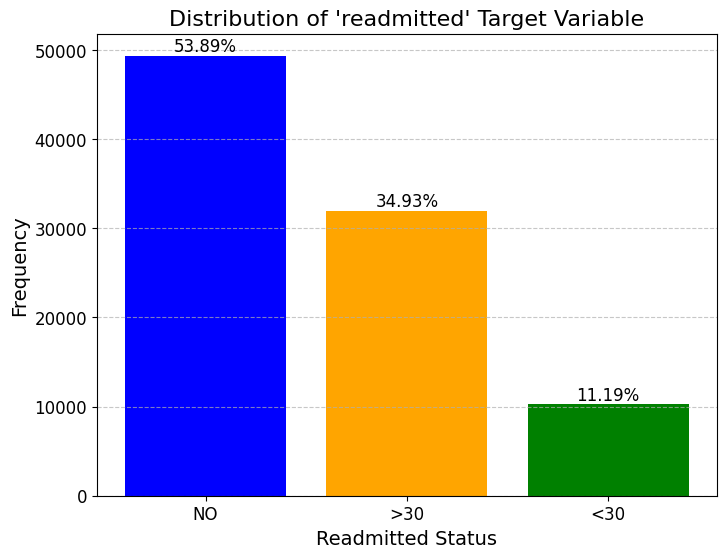

In [192]:
def plotReadmittedDistribution():
    '''
    Function to plot the distribution of the 'readmitted' target variable
    '''

    readmitted_counts = df_train['readmitted'].value_counts()
    readmitted_percentages = (readmitted_counts / len(df_train)) * 100

    # Plot the distribution
    plt.figure(figsize=(8, 6))
    bars = plt.bar(readmitted_counts.index, readmitted_counts, color=['blue', 'orange', 'green'])
    plt.title("Distribution of 'readmitted' Target Variable", fontsize=16)
    plt.xlabel("Readmitted Status", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Annotate bars with percentages
    for bar, percentage in zip(bars, readmitted_percentages):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                f'{percentage:.2f}%', ha='center', va='bottom', fontsize=12)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plotReadmittedDistribution()

We have grouped different diagnosis codes into 3 categories

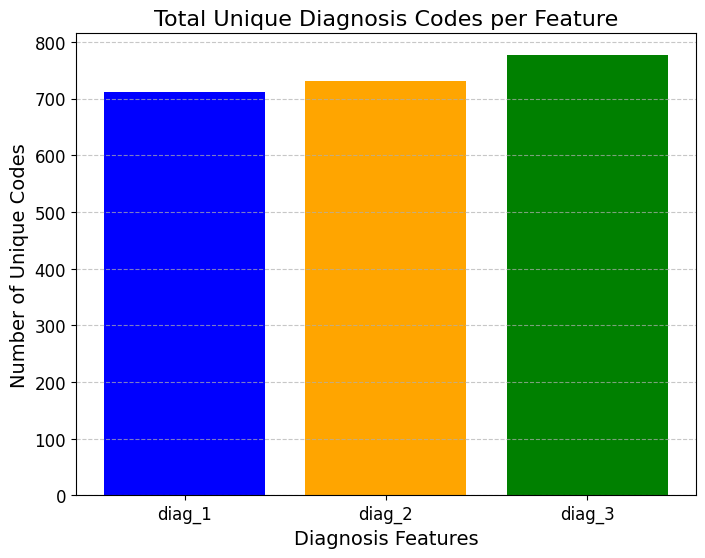

In [193]:
def plotUniqueDiagnosisCodes():
    '''
    Function to plot the total unique diagnosis codes per feature
    '''
    diag_columns = ['diag_1', 'diag_2', 'diag_3']
    unique_diagnosis_counts = {col: df_train[col].nunique() for col in diag_columns}

    plt.figure(figsize=(8, 6))
    plt.bar(unique_diagnosis_counts.keys(), unique_diagnosis_counts.values(), color=['blue', 'orange', 'green'])
    plt.title("Total Unique Diagnosis Codes per Feature", fontsize=16)
    plt.xlabel("Diagnosis Features", fontsize=14)
    plt.ylabel("Number of Unique Codes", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()

plotUniqueDiagnosisCodes()

## Data Visualization

Race: Caucasian > AfricanAmerican > Asian, but the distribution is quite similar, so we normally encode them, and impute NaN values

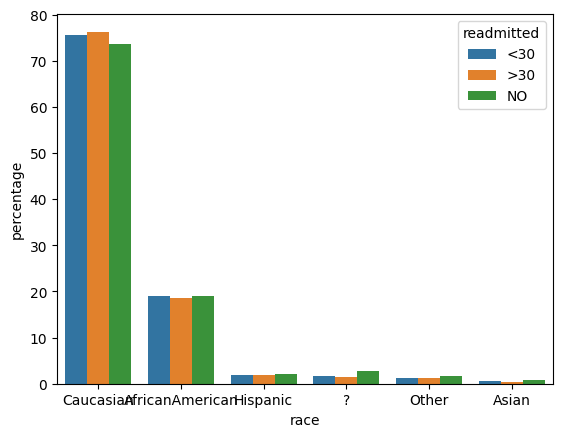

In [194]:
barplot_per_classes(df_train, 'race', 'readmitted')

Gender : There is no huge difference between male and female, so we normally encode them and impute NaN/Delete

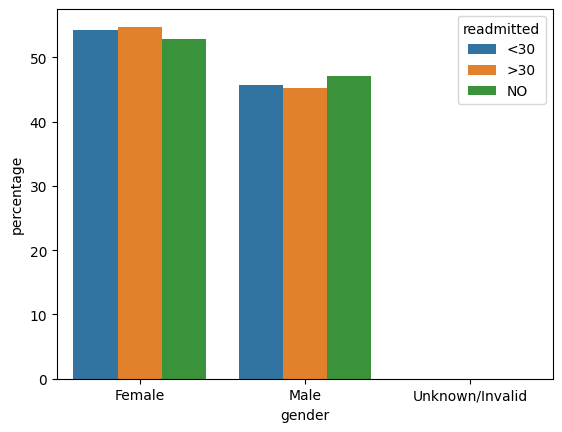

In [195]:
barplot_per_classes(df_train, 'gender', 'readmitted')

Age: the number of patients over 40 years old is higher than below 40 years old. And 70-80 is the highest.

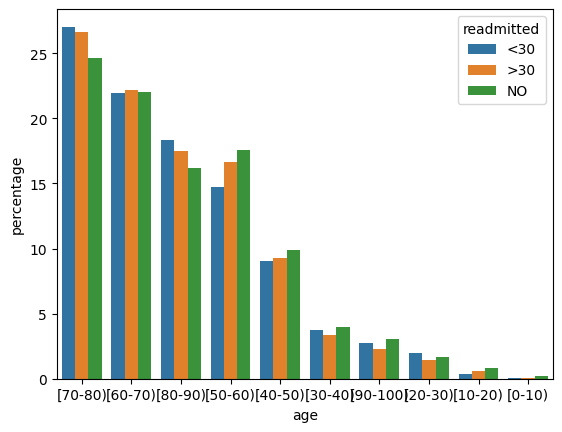

In [196]:
barplot_per_classes(df_train, 'age', 'readmitted')

Admission Type ID: The Emergency domained, followed by Elective. We can group them

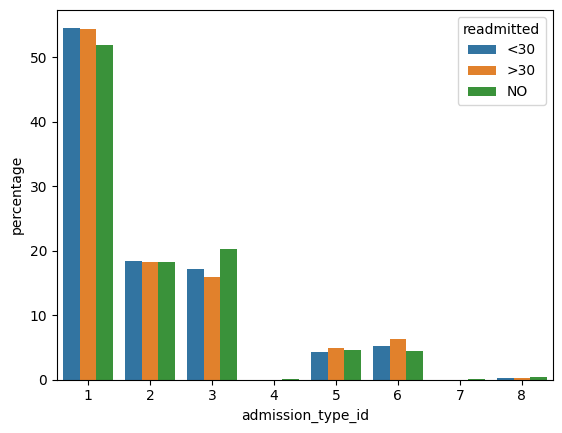

In [197]:
barplot_per_classes(df_train, 'admission_type_id', 'readmitted')

Discharge Disposition ID: There are 29 categories. We group them.

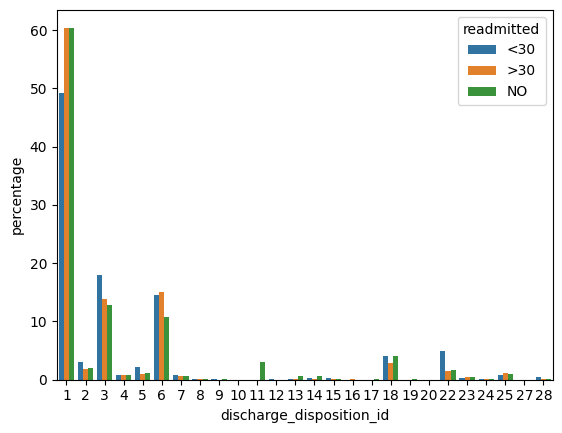

In [198]:
barplot_per_classes(df_train, 'discharge_disposition_id', 'readmitted')

Admission Source ID

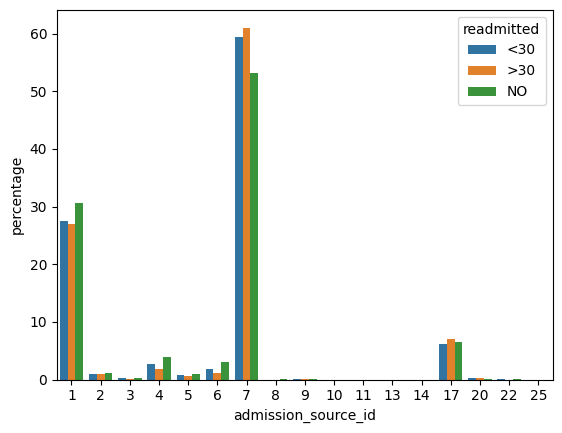

In [199]:
barplot_per_classes(df_train, 'admission_source_id', 'readmitted')

Time in hospital

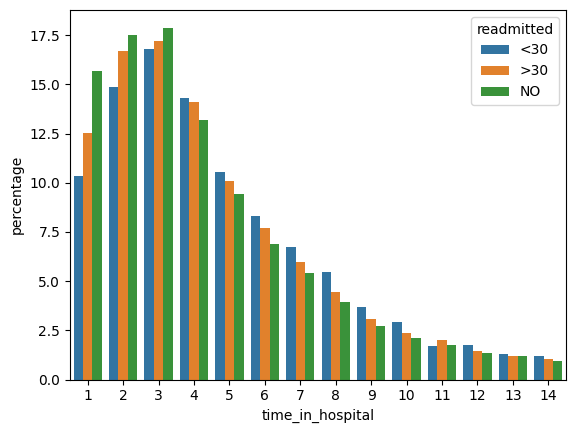

In [200]:
barplot_per_classes(df_train, 'time_in_hospital', 'readmitted')

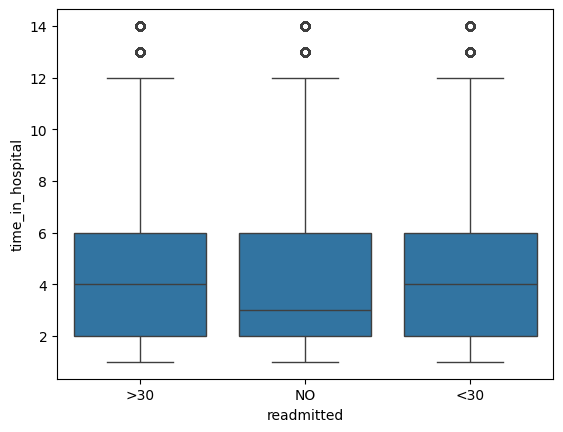

In [201]:
boxplot_per_classes(df_train, 'time_in_hospital', 'readmitted')

num_lab_procedures

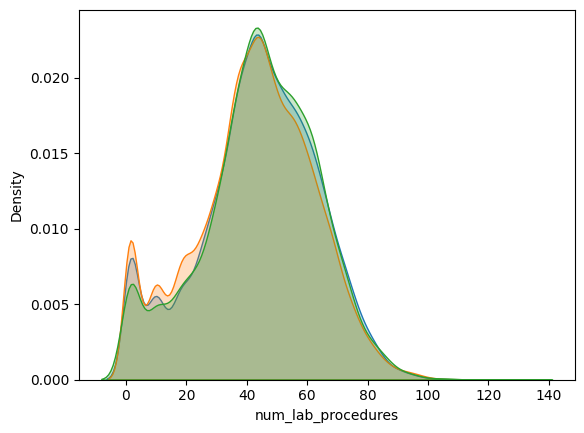

In [202]:
kdeplot_per_classes(df_train, 'num_lab_procedures', 'readmitted')

num_procedure

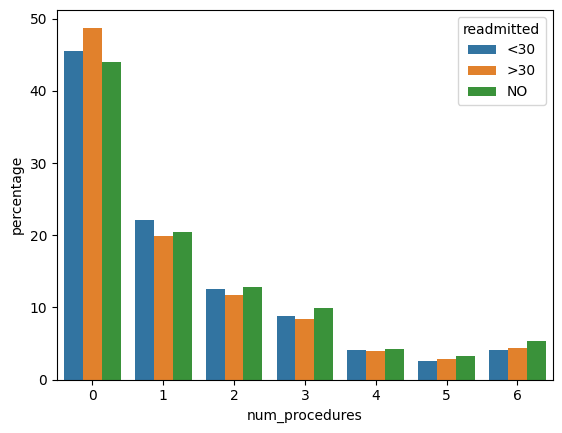

In [203]:
barplot_per_classes(df_train, 'num_procedures', 'readmitted')

num_medication


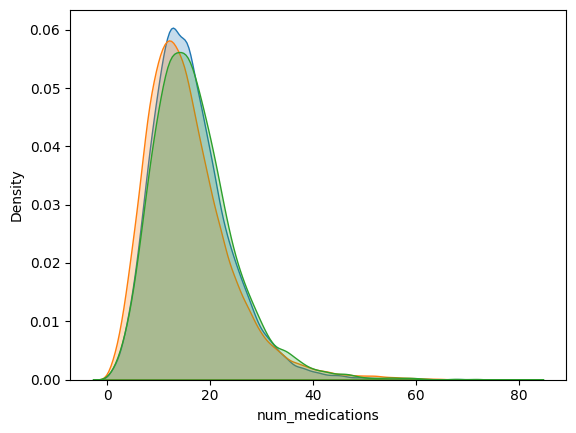

In [204]:
kdeplot_per_classes(df_train, 'num_medications', 'readmitted')

number_outpatient; number_inpatient; number_emergency: the distribution of these three features are similar. we can consider to group them into 1 feature

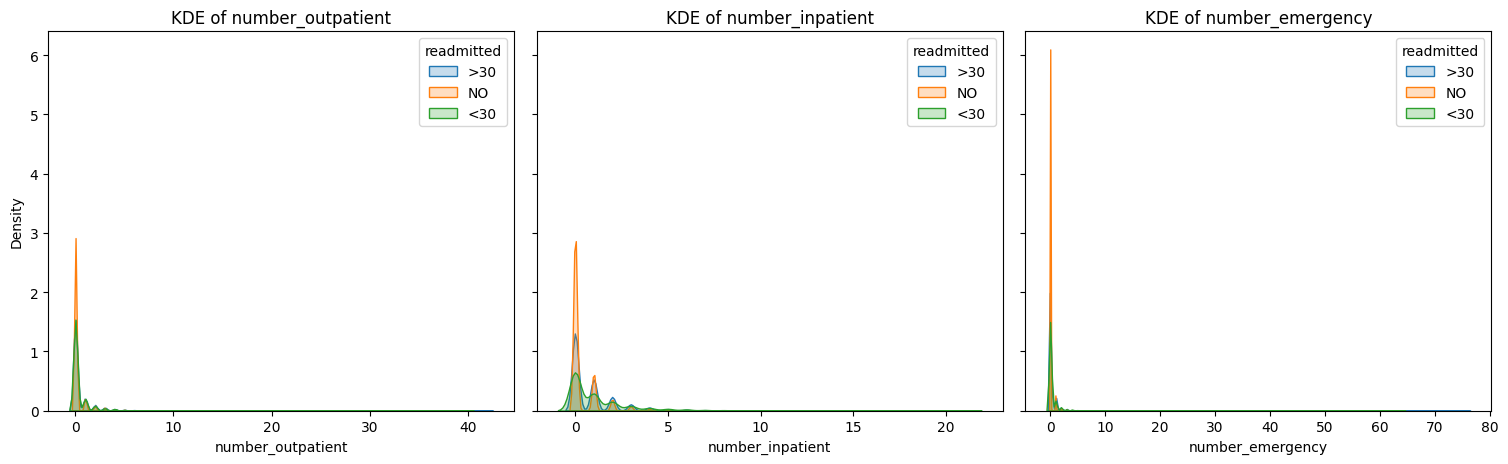

In [205]:
kdeplot_multi_classes(df_train, ['number_outpatient',"number_inpatient","number_emergency"], 'readmitted')

payer_code

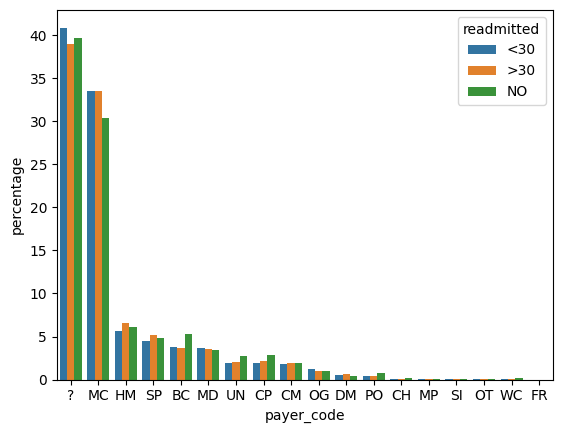

In [206]:
barplot_per_classes(df_train, 'payer_code', 'readmitted')

medical_specialty

In [207]:
df_train["medical_specialty"].value_counts()

medical_specialty
?                                   44992
InternalMedicine                    13191
Emergency/Trauma                     6808
Family/GeneralPractice               6711
Cardiology                           4776
                                    ...  
Psychiatry-Addictive                    1
Perinatology                            1
Neurophysiology                         1
Pediatrics-InfectiousDiseases           1
Surgery-PlasticwithinHeadandNeck        1
Name: count, Length: 73, dtype: int64

Medicaments: examide;citoglipton;glimepiride-pioglitazone only have 1 value NO which can be deleted.

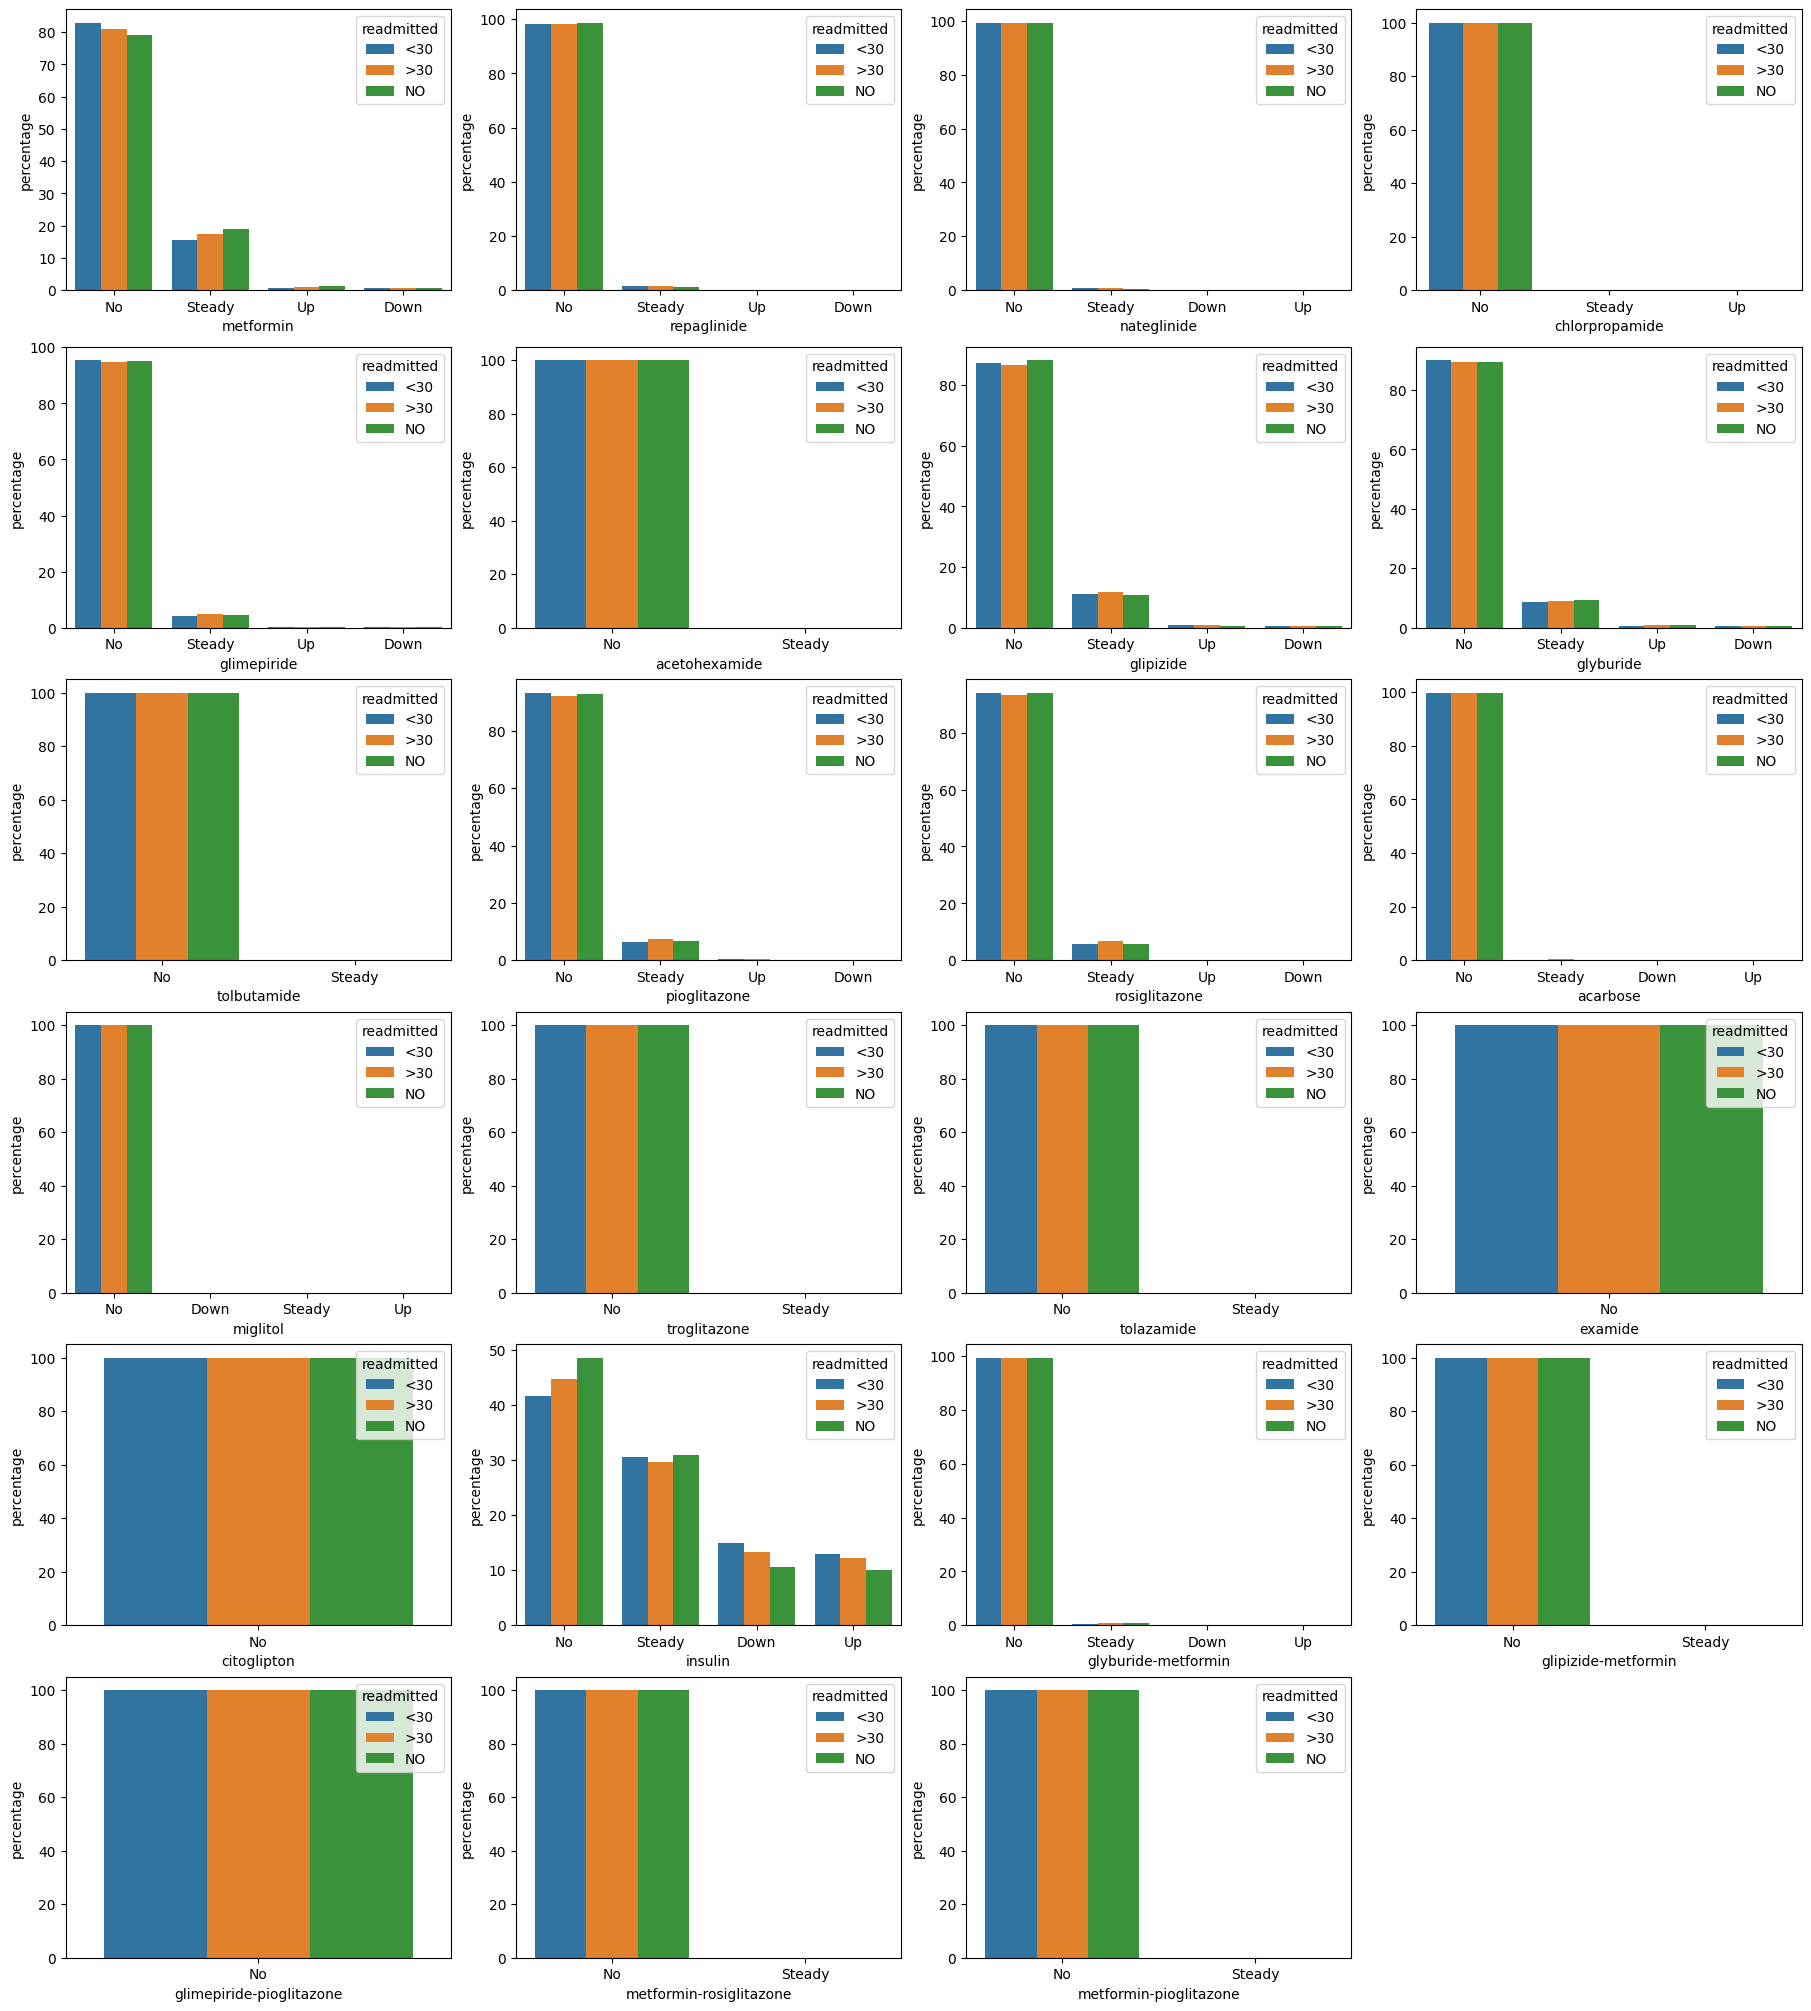

In [208]:
fig, axs = plt.subplots(nrows=6, ncols=4, constrained_layout=True)
fig.delaxes(axs[5,3])
all_medicaments = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide','glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide',
    'citoglipton', 'insulin','glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
]
fig.set_size_inches(18, 20)
for y in range(0,6):
    for x in range(0,4):
        if x + 4 * y == len(all_medicaments):
            break
        barplot_per_classes(df_train, all_medicaments[x + 4 * y], 'readmitted', ax=axs[y][x])

### Transformers
All the transformers are defined in the following cell. The transformers are used to preprocess the data before feeding it to the classifiers.

In [5]:
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        """
        Custom transformer to drop specified columns.
        :param columns_to_drop: List of column names to drop
        """
        self.columns_to_drop = columns_to_drop if columns_to_drop else []

    def fit(self, X, y=None):
        # Nothing to fit; just return self
        return self
    
    def transform(self, X):
        """
        Drop the specified columns from the DataFrame.
        :param X: Input DataFrame
        :return: Transformed DataFrame with specified columns dropped
        """
        return X.drop(columns=self.columns_to_drop)
    
class DropRowsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, conditions=None):
        """
        Custom transformer to drop rows based on specified conditions.
        :param conditions: List of conditions (functions) to drop rows
        """
        self.conditions = conditions if conditions else []

    def fit(self, X, y=None):
        # Nothing to fit; just return self
        return self
    
    def transform(self, X):
        """
        Drop rows based on specified conditions.
        :param X: Input DataFrame
        :return: Transformed DataFrame with rows dropped based on conditions
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame.")
        for condition in self.conditions:
            X = X[~condition(X)]
        return X
    
class ModelImputationTransformer(BaseEstimator, TransformerMixin):
    """
    A custom transformer that uses a multi-output model (e.g., MultiOutputClassifier)
    to impute missing values for specified target columns.
    """

    def __init__(self, target_features=None, base_model=None):
        """
        :param target_features: list[str], the names of the columns to be imputed.
        :param base_model: The classifier (or regressor) to be used. 
                          Defaults to MultiOutputClassifier(LogisticRegression()).
        """
        self.target_features = target_features or []
        self.base_model = base_model or MultiOutputClassifier(LogisticRegression())
        self.input_features_ = None  # Will be inferred at fit time
        self.fitted_model_ = None

    def fit(self, X, y=None):
        """
        In the fit phase, select rows where the target_features are not missing
        and use them to train the model.
        """
        # 1) Copy X to avoid modifying it in place
        df = X.copy()
        # 2) Input features = all columns in X that are not in target_features
        #    (Assuming target_features exist in X)
        self.input_features_ = [col for col in df.columns if col not in self.target_features]
        # 3) Filter rows where all target_features are non-missing (for training)
        train_data = df.dropna(subset=self.target_features)
        X_train = train_data[self.input_features_]
        y_train = train_data[self.target_features]
        # 4) Train the multi-output model
        self.base_model.fit(X_train, y_train)
        self.fitted_model_ = self.base_model  # Store the trained model for use in transform

        return self

    def transform(self, X):
        """
        In the transform phase, use the trained model to predict and fill in 
        missing values for the target_features.
        """
        if self.fitted_model_ is None:
            # If transform is called before fit, choose to either return X or raise an error
            return X  

        df = X.copy()
        # 1) Identify rows where any of the target_features are missing
        missing_mask = df[self.target_features].isna().any(axis=1)
        test_data = df[missing_mask]

        # 2) If there are no missing values, simply return df
        if test_data.empty:
            return df
        
        # 3) Predict values for rows with missing data
        X_test = test_data[self.input_features_]
        y_pred = self.fitted_model_.predict(X_test)

        # 4) Fill in the predicted values
        for idx, col in enumerate(self.target_features):
            # Find rows where the current column is missing
            col_nan_mask = test_data[col].isna()
            # Assign the predicted values to those rows
            test_data.loc[col_nan_mask, col] = y_pred[col_nan_mask, idx]

        # 5) Update df with the newly imputed values
        df.loc[missing_mask, self.target_features] = test_data[self.target_features]
        return df

class EncodeRaceTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="race"):
        """
        Custom transformer to encode the race column.
        :param column: The column name to encode.
        """
        self.column = column
        self.race_map = {
            "Caucasian": 0,
            "Asian": 1,
            "AfricanAmerican": 2,
            "Hispanic": 3,
            "Other": 4,
            "?": -1
        }

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """
        Encode the specified column using the predefined mapping.
        :param X: Input DataFrame
        :return: Transformed DataFrame with the encoded column.
        """
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].fillna(-99)
            X[self.column] = X[self.column].map(self.race_map).astype(int)

        return X
    
class EncodeRaceImputationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="race"):
        """
        Custom transformer to encode the race column.
        :param column: The column name to encode.
        """
        self.column = column
        self.race_map = {
            "Caucasian": 0,
            "Asian": 1,
            "AfricanAmerican": 2,
            "Hispanic": 3,
            "Other": 4,
            "?": None
        }

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """
        Encode the specified column using the predefined mapping.
        :param X: Input DataFrame
        :return: Transformed DataFrame with the encoded column.
        """
        X = X.copy()
        if self.column in X:
            #X[self.column] = X[self.column].fillna(-1)
            X[self.column] = X[self.column].map(self.race_map)#.astype(int)

        return X
        
class EncodeGenderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="gender"):
        """
        Encodes gender column
        """
        self.column = column
        self.gender_map = {
            "Female": 0, 
            "Male": 1, 
            "Unknown/Invalid": -1
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Encode the specified column using the predefined mapping.
        """
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].fillna(-99) 
            X[self.column] = X[self.column].map(self.gender_map).astype(int)

        return X
    
class EncodeGenderImputationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="gender"):
        """
        Encodes gender column
        """
        self.column = column
        self.gender_map = {
            "Female": 0, 
            "Male": 1, 
            "Unknown/Invalid": None
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Encode the specified column using the predefined mapping.
        """
        X = X.copy()
        if self.column in X:
            #X[self.column] = X[self.column].fillna(-1) 
            X[self.column] = X[self.column].map(self.gender_map)#.astype(int)

        return X
    
class EncodeAgeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="age"):
        """
        Encodes age column
        """
        self.column = column
        self.age_map = {
            "[0-10)": 0,
            "[10-20)": 10,
            "[20-30)": 20,
            "[30-40)": 30,
            "[40-50)": 40,
            "[50-60)": 50,
            "[60-70)": 60,
            "[70-80)": 70,
            "[80-90)": 80,
            "[90-100)": 90
        }
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.age_map).astype(int)

        return X
    
class AdmissionTypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="admission_type_id"):
        """
        Group different admission_type_id into 5 classes based on the original type,
        which contains 8 categories. The mapping is as follows:
            - Class 0 : Emergency
            - Class 1 : Elective - Planned admissions.
            - Class 2 : Newborn - Admissions for newborns.
            - Class 3 : Not Available and NULL - Missing information about admission type.
            - Class 4 : Trauma Center
            - Class 5 : Not Mapped
        """
        self.column = column
        self.admission_type_id_map = {
            1: 0,  # Emergency
            2: 0,  # Urgent
            3: 1,  # Elective
            4: 2,  # Newborn
            5: 3,  # Not Available
            6: 3,  # NULL
            7: 4,  # Trauma Center
            8: 5   # Not Mapped
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.admission_type_id_map)

        return X
        
class DischargeDispositionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="discharge_disposition_id"):
        """
        Group different discharge_disposition_id into 13 classes based on the original type,
        which contains 30 categories. The mapping is as follows:
            - Class 0 : Home-Based Care: Represents situations where the patient is discharged to their home environment. (1, 6, 8)
            - Class 1 : Hospice Care: Represents patients who were transferred to receive end-of-life care in a home or facility. (13, 14)
            - Class 2 : Rehabilitation/Long-Term Care: Represents patients transferred to a facility for ongoing care, rehabilitation, or specialized nursing. (3, 4, 15, 22, 23, 24, 30)
            - Class 3 : Transferred to Another Institution for Continued Care: Represents transfers to other institutions where further but similar levels of care are continued. (2, 5, 27, 29)
            - Class 4 : Transferred for Specialized or Critical Care: Represents patients transferred for more specialized care or critical conditions. (28, 7)
            - Class 5 : Neonatal Aftercare: Represents newborn patients discharged to a specialized neonatal care unit. (10)
            - Class 6 : Psychiatric Care: Represents patients discharged to a psychiatric hospital or distinct psychiatric unit. (28)
            - Class 7 : Outpatient Referral: Represents cases where the patient is discharged with a recommendation to continue treatment as an outpatient. (16, 17)
            - Class 8 : Expired: Represents patients who passed away during the course of treatment. (11, 19, 20, 21)
            - Class 9 : Ongoing Care: Represents patients who are still in care or expected to return for further treatment. (12)
            - Class 10 : Left AMA: Represents patients who left the hospital against medical advice. (7)
            - Class 11 : Not Mapped: Represents discharge types that do not match any pre-defined categories in the system. (25)
            - Class 12 : Unknown/Invalid: Represents instances where discharge information is unknown or invalid. (18, 26)
        """
        self.column = column
        self.discharge_disposition_mapping = {
            1: 0, 6: 0, 8: 0,  # Home-Based Care
            13: 1, 14: 1,      # Hospice Care
            3: 2, 4: 2, 15: 2, 22: 2, 23: 2, 24: 2, 30: 2,  # Rehabilitation/Long-Term Care
            2: 3, 5: 3, 27: 3, 29: 3,  # Transferred to Another Institution for Continued Care
            9: 4,        # Transferred for Specialized or Critical Care
            10: 5,              # Neonatal Aftercare
            28: 6,              # Psychiatric Care
            16: 7, 17: 7,       # Outpatient Referral
            11: 8, 19: 8, 20: 8, 21: 8,  # Expired
            12: 9,              # Ongoing Care
            7: 10,              # Left AMA
            25: 11,             # Not Mapped
            18: 12, 26: 12      # Unknown/Invalid
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.discharge_disposition_mapping)
        return X 

class CreateUtilizationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=["number_inpatient", "number_outpatient", "number_emergency"]):
        """
        Add three features to reduce the dataset dimension as their distributions are the same.
        """
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["utilization"] = X[self.columns[0]] + X[self.columns[1]] + X[self.columns[2]]
        return X 

class RemoveOutliersTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses']):
        """
        Add three features to reduce the dataset dimension as their distributions are the same.
        """
        self.columns = columns

    def fit(self, X, y=None):
        self.bounds_ = {}
        for feature in self.columns:
            Q1 = X[feature].quantile(0.25)
            Q3 = X[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = max(0, Q1 - 1.5 * IQR)
            upper_bound = Q3 + 1.5 * IQR
            self.bounds_[feature] = (lower_bound, upper_bound)
        return self

    def transform(self, X):
        df = X.copy()
        for feature in self.columns:
            lower_bound, upper_bound = self.bounds_[feature]
            df[feature] = df[feature].clip(lower=lower_bound, upper=upper_bound)
            #df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
        return df
    
class AdmissionSourceTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="admission_source_id"):
        """
        Group different admission_source_id into 6 classes based on the original type,
        which contains 25 categories. The mapping is as follows:
            - Class 1 : Referrals
            - Class 2 : Transfers from Other Healthcare Facilities
            - Class 3 : Emergency or Law Enforcement
            - Class 4 : Birth-Related Admissions
            - Class 5 : Readmissions and Home Health Agencies
            - Class 6 : Unknown or Invalid
        """
        self.column = column
        self.admission_source_id_map = {
            1: 1, 2: 1, 3: 1,  # Referrals
            4: 2, 5: 2, 6: 2, 10: 2, 18: 2, 22: 2, 25: 2, 26: 2,  # Transfers
            7: 3, 8: 3,        # Emergency or Law Enforcement
            11: 4, 12: 4, 13: 4, 14: 4, 23: 4, 24: 4,  # Birth-Related Admissions
            19: 5,             # Readmissions and Home Health Agencies
            9: 6, 15: 6, 17: 6, 20: 6, 21: 6  # Unknown or Invalid
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.admission_source_id_map)
        return X
    
class DiagnosisTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, diag_columns=None, threshold=3.0):
        """
        Transformer to process diagnosis columns (diag_1, diag_2, diag_3).
        :param diag_columns: List of columns containing ICD-9 diagnosis codes.
        :param threshold: Percentage threshold to keep categories.
        """
        self.diag_columns = diag_columns if diag_columns else ["diag_1", "diag_2", "diag_3"]
        self.threshold = threshold
        self.diagnosis_to_keep = []

    def _map_icd9_to_category(self, icd_code):
        """
        Maps ICD-9 codes to categories based on predefined rules.
        """
        if icd_code == "?":
            return "Missing"
        if str(icd_code).startswith("E") or str(icd_code).startswith("V"):
            return "External"
        try:
            code = int(float(icd_code))
        except ValueError:
            return "Invalid"
        
        if code in range(390, 460) or code == 785:
            return "Circulatory"
        elif code in range(460, 520) or code == 786:
            return "Respiratory"
        elif code in range(520, 580) or code == 787:
            return "Digestive"
        elif code in range(580, 630) or code == 788:
            return "Genitourinary"
        elif code == 250:
            return "Diabetes"
        elif code in range(800, 1000):
            return "Injury"
        elif code in range(710, 739):
            return "Musculoskeletal"
        elif code in range(140, 240):
            return "Neoplasms"
        elif code in range(790, 800) or code in [780, 781, 784]:
            return "Other_Symptoms"
        elif code in range(240, 280) and code != 250:
            return "Endocrine"
        elif code in range(680, 710) or code == 782:
            return "Skin"
        elif code in range(1, 140):
            return "Infectious"
        elif code in range(290, 320):
            return "Mental"
        elif code in range(280, 290):
            return "Blood"
        elif code in range(320, 360):
            return "Nervous"
        elif code in range(630, 680):
            return "Pregnancy"
        elif code in range(360, 390):
            return "Sense"
        elif code in range(740, 760):
            return "Congenital"
        else:
            return "Other"

    def _get_diagnosis_to_keep(self, df):
        """
        Get the list of diagnosis categories that have more than `threshold` percentage of patients.
        """
        # Flatten the diagnosis columns into one
        flattened = pd.concat([df[col] for col in self.diag_columns])
        flattened = flattened.apply(lambda x: self._map_icd9_to_category(x))

        # Calculate percentage counts for each unique category
        category_percentages = flattened.value_counts(normalize=True) * 100

        # Filter categories with percentage >= threshold
        categories_to_keep = category_percentages[category_percentages >= self.threshold].index.tolist()
        if "Other" not in categories_to_keep:
            categories_to_keep.append("Other")
        return categories_to_keep
    
    def fit(self, X, y=None):
        """
        Fit the transformer by determining which diagnosis categories to keep.
        """
        self.diagnosis_to_keep = self._get_diagnosis_to_keep(X)
        return self
    
    def transform(self, X):
        """
        Transform the diagnosis columns to categories and one-hot encode the significant ones.
        """
        
        X = X.copy()
        
        # Map ICD-9 codes to categories and group insignificant ones into "Other"
        for col in self.diag_columns:
            X[col] = X[col].apply(lambda x: self._map_icd9_to_category(x))
            X[col] = X[col].apply(lambda x: x if x in self.diagnosis_to_keep else "Other")
        
        # Create one-hot encoded columns for each category
        for kept_diag in self.diagnosis_to_keep:
            X[kept_diag] = 0
            for col in self.diag_columns:
                X[kept_diag] += X[col].apply(lambda x: 1 if x == kept_diag else 0)

        # Drop original diagnosis columns
        X = X.drop(columns=self.diag_columns)
        return X
    
class DiagnosisNoOneHotTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        """
        Transformer to process diagnosis columns (diag_1, diag_2, diag_3).
        :param diag_columns: List of columns containing ICD-9 diagnosis codes.
        :param diagnosis_mapping: map to categorical integer value
        """
        self.columns = columns if columns else ["diag_1", "diag_2", "diag_3"]
        self.diagnosis_mapping = {
            "Circulatory": 0,
            "Respiratory": 1,
            "Digestive": 2,
            "Genitourinary": 3,
            "Diabetes": 4,
            "Injury": 5,
            "Musculoskeletal": 6,
            "Neoplasms": 7,
            "Other_Symptoms": 8,
            "Endocrine": 9,
            "Skin": 10,
            "Infectious": 11,
            "Mental": 12,
            "Blood": 13,
            "Nervous": 14,
            "Pregnancy": 15,
            "Sense": 16,
            "Congenital": 17,
            "Other": 18,
            "External": 19,
            "Missing": None   # For any undefined cases
        }

    def _map_icd9_to_category(self, icd_code):
        """
        Maps ICD-9 codes to categories based on predefined rules.
        """
        if icd_code == "?":
            return "Missing"
        if str(icd_code).startswith("E") or str(icd_code).startswith("V"):
            return "External"
        try:
            code = int(float(icd_code))
        except ValueError:
            return "Invalid"
        
        if code in range(390, 460) or code == 785:
            return "Circulatory"
        elif code in range(460, 520) or code == 786:
            return "Respiratory"
        elif code in range(520, 580) or code == 787:
            return "Digestive"
        elif code in range(580, 630) or code == 788:
            return "Genitourinary"
        elif code == 250:
            return "Diabetes"
        elif code in range(800, 1000):
            return "Injury"
        elif code in range(710, 739):
            return "Musculoskeletal"
        elif code in range(140, 240):
            return "Neoplasms"
        elif code in range(790, 800) or code in [780, 781, 784]:
            return "Other_Symptoms"
        elif code in range(240, 280) and code != 250:
            return "Endocrine"
        elif code in range(680, 710) or code == 782:
            return "Skin"
        elif code in range(1, 140):
            return "Infectious"
        elif code in range(290, 320):
            return "Mental"
        elif code in range(280, 290):
            return "Blood"
        elif code in range(320, 360):
            return "Nervous"
        elif code in range(630, 680):
            return "Pregnancy"
        elif code in range(360, 390):
            return "Sense"
        elif code in range(740, 760):
            return "Congenital"
        else:
            return "Other"
    
    def fit(self, X, y=None):
        """
        Fit the transformer
        """
        #self.diagnosis_to_keep = self._get_diagnosis_to_keep(X)
        return self
    
    def transform(self, X):
        """
        Encode values
        """
        X = X.copy()
        for col in self.columns:
            if col in X.columns:
                X[col] = X[col].apply(self._map_icd9_to_category).replace(self.diagnosis_mapping)
        return X
    
class MaxGluSerumTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="max_glu_serum"):
        """
        Custom transformer to encode max_glu_serum values.
        :param column: The column to transform.
        """
        self.column = column
        self.mapping = {
            "Norm": 1,
            ">200": 2,
            ">300": 3
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.mapping)
            X[self.column] = X[self.column].fillna(-99)
        return X

class MedicalSepcialtyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="medical_specialty"):
        """
        Custom transformer to encode medical_specialty values.
        :param column: The column to transform.
        """
        self.column = column
        self.mapping = {
        # Pediatrics (Child/Adolescent Care)
        'Pediatrics-Endocrinology': 0,
        'Pediatrics-Pulmonology': 0,
        'Pediatrics-AllergyandImmunology': 0,
        'Pediatrics-InfectiousDiseases': 0,
        'Pediatrics-CriticalCare': 0,
        'Pediatrics-EmergencyMedicine': 0,
        'Pediatrics-Hematology-Oncology': 0,
        'Cardiology-Pediatric': 0,
        'Anesthesiology-Pediatric': 0,
        'Psychiatry-Child/Adolescent': 0,
        'Pediatrics-Neurology':0,
        'Surgery-Pediatric': 0,

        # Obstetrics and Gynecology (Women’s Health)
        'Obstetrics': 1,
        'ObstetricsandGynecology': 1,
        'Gynecology': 1,
        'Obsterics&Gynecology-GynecologicOnco': 1,
        'Perinatology': 1,

        # Internal Medicine
        'InternalMedicine': 2,
        'Cardiology': 2,
        'Pulmonology': 2,
        'Endocrinology': 2,
        'Endocrinology-Metabolism': 2,
        'Hematology': 2,
        'Nephrology': 2,
        'Rheumatology': 2,
        'Gastroenterology': 2,
        'Hematology/Oncology': 2,
        'Hospitalist': 2,
        'AllergyandImmunology': 2,
        'InfectiousDiseases': 2,
        'Urology': 2,
        'Family/GeneralPractice': 2,

        # Surgical Specialties
        'Surgery-General': 3,
        'Surgery-Pediatric': 3,
        'Surgery-Cardiovascular': 3,
        'Surgery-Cardiovascular/Thoracic': 3,
        'Surgery-Thoracic': 3,
        'Surgery-Vascular': 3,
        'Surgery-Plastic': 3,
        'Surgery-PlasticwithinHeadandNeck': 3,
        'Surgery-Colon&Rectal': 3,
        'Surgery-Neuro': 3,
        'Surgery-Maxillofacial': 3,
        'Orthopedics': 3,
        'Orthopedics-Reconstructive': 3,
        'Proctology': 3,
        'SurgicalSpecialty':3,
        'Emergency/Trauma': 3,

        # Neurology and Psychiatry
        'Neurology': 4,
        'Neurophysiology': 4,
        'Psychiatry': 4,
        'Psychiatry-Addictive': 4,
        'Psychiatry-Child/Adolescent': 4,
        'Psychology': 4,

        # Oncology
        'Hematology/Oncology': 5,
        'Oncology': 5,

        # Diagnostic and Therapeutic Specialties
        'Radiology': 6,
        'Radiologist': 6,
        'Pathology': 6,
        'Anesthesiology': 6,
        'Anesthesiology-Pediatric': 6,

        # Rehabilitation and Physical Health
        'PhysicalMedicineandRehabilitation': 7,
        'SportsMedicine': 7,

        # ENT and Sensory Systems
        'Otolaryngology': 8,
        'Ophthalmology': 8,

        # Dental and Podiatric Specialties
        'Dentistry': 9,
        'Podiatry': 9,

        # Miscellaneous or Undefined
        'DCPTEAM': 10,
        'OutreachServices': 10,
        'Speech': 10,
        'Surgeon': 10,
        'Osteopath': 10,
        'PhysicianNotFound': 10,
        'Dermatology': 10,
        'Resident': 10,
        # Encode Missing 
        '?': -99}


    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.mapping)
            X[self.column] = X[self.column].fillna(-99)
        return X 
    
class A1CResultTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="A1Cresult"):
        """
        Custom transformer to encode A1Cresult values.
        :param column: The column to transform.
        """
        self.column = column
        self.mapping = {
            "Norm": 1,
            ">7": 2,
            ">8": 3
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.mapping)
            X[self.column] = X[self.column].fillna(-99)
        return X

class MedicinesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        """
        Custom transformer to process medication columns.
        Groups medications into broader categories, creates features for the number of medications used,
        and adds temporal features for medication changes.
        """
        self.categories = {
            'Biguanides': [
                'metformin', 'glyburide-metformin', 'glipizide-metformin',
                'metformin-rosiglitazone', 'metformin-pioglitazone'
            ],
            'Meglitinides': ['repaglinide', 'nateglinide'],
            'Sulfonylureas': [
                'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
                'glyburide', 'tolbutamide', 'tolazamide', 'examide', 'glyburide-metformin',
                'glipizide-metformin', 'glimepiride-pioglitazone'
            ],
            'Thiazolidinediones (TZDs)': [
                'pioglitazone', 'rosiglitazone', 'troglitazone', 'glimepiride-pioglitazone',
                'metformin-rosiglitazone', 'metformin-pioglitazone'
            ],
            'Alpha-Glucosidase Inhibitors': ['acarbose', 'miglitol'],
            'Insulin': ['insulin']
        }
        self.all_medication = [med for meds in self.categories.values() for med in meds]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        # Drop the citoglipton column if it exists
        if 'citoglipton' in X.columns:
            X.drop(columns=['citoglipton'], inplace=True)

        # Create temporal features for medication changes
        X = self._create_temporal_features(X)

        # Group medications into broader categories and count the number of medications used
        X = self._combine_medication(X)
        
        return X 
    
    def _combine_medication(self, X):
        """
        Groups medications into broader categories and counts the number of used medicines.
        """
        category_df = pd.DataFrame()
        for category, meds in self.categories.items():
            category_df[category] = (X[meds] != "No").sum(axis=1).astype(int)

        # Drop the original medication columns and concatenate the new features
        X.drop(columns=self.all_medication, inplace=True)
        X = pd.concat([X, category_df], axis=1)
        return X
    
    def _create_temporal_features(self, X):
        """
        Creates temporal features that capture increases and decreases in medication doses.
        """
        increases = X[self.all_medication].apply(
            lambda row: sum(1 for val in row if val == 'Up'), axis=1)
        decreases = X[self.all_medication].apply(
            lambda row: sum(1 for val in row if val == 'Down'), axis=1)

        # Add new features to the DataFrame
        X['total_dose_changes'] = increases - decreases
        X['dose_change_ratio'] = X.apply(
            lambda row: (
                0 if increases[row.name] == 0 and decreases[row.name] == 0  # No changes
                else 0.5 if increases[row.name] == decreases[row.name]      # Equal ups/downs
                else increases[row.name] - decreases[row.name]
            ), axis=1)     
           
        return X

class ChangeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="change"):
        """
        Custom transformer to encode the change feature.
        :param column: The column to transform.
        """
        self.column = column
        self.mapping = {"No": 0, "Ch": 1}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.mapping).astype(int)
        return X
    
class DiabetesMedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="diabetesMed"):
        """
        Custom transformer to encode the diabetesMed feature.
        :param column: The column to transform.
        """
        self.column = column
        self.mapping = {"No": 0, "Yes": 1}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.mapping).astype(int)
        return X
    
class ReadmittedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="readmitted"):
        """
        Custom transformer to encode the readmitted feature.
        :param column: The column to transform.
        """
        self.column = column
        self.mapping = {">30": 1, "<30": 0, "NO": 2}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.mapping).astype(int)
        return X

class ReadmittedTransformer_2models(BaseEstimator, TransformerMixin):
    def __init__(self, column="readmitted"):
        """
        Custom transformer to encode the readmitted feature.
        :param column: The column to transform.
        """
        self.column = column
        self.mapping = {">30": 0, "<30": 0, "NO": 1}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.mapping).astype(int)
        return X

class CollapseDuplicatedPatientsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, version: str = "manual"):
        """
        Custom transformer to collapse duplicated patient rows.
        """
        self.version = version

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()

        if self.version == "keep first":
            # Keep the first encounter for each patient
            df = df.drop_duplicates(subset=['patient_nbr'], keep='first')

        elif self.version == "keep last":
            # Keep the last encounter for each patient
            df = df.drop_duplicates(subset=['patient_nbr'], keep='last')

        elif self.version == "longest stay":
            # Keep the encounter with the longest hospital stay
            if 'time_in_hospital' in df.columns:
                df = df.loc[
                    df.groupby('patient_nbr')['time_in_hospital'].idxmax()]
            else:
                raise ValueError(
                    "The 'time_in_hospital' column is missing for this version.")

        elif self.version == "manual":
            # List of features to calculate the average for
            # features_to_average = [
            #     'time_in_hospital', 'num_lab_procedures', 'num_procedures',
            #     'num_medications', 'number_outpatient', 'number_emergency',
            #     'number_inpatient'
            # ]
            features_to_average = [
                'time_in_hospital'
            ]

            # Calculate the average for each feature in the list
            avg_features = df.groupby('patient_nbr')[
                features_to_average].mean().reset_index()

            # Count the number of encounters for each patient
            encounter_counts = df.groupby('patient_nbr').size().reset_index(
                name='encounter_times')

            # Handle the `diabetesMed` feature: retain 1 if it exists for any encounter
            diabetes_med_flag = df.groupby('patient_nbr')[
                'diabetesMed'].max().reset_index()

            # Keep the first encounter for all other features
            first_encounter = df.drop_duplicates(subset=['patient_nbr'],
                                                 keep='first')

            # Drop `time_in_hospital` and `diabetesMed` from the first encounter to avoid duplication
            first_encounter = first_encounter.drop(
                columns=['time_in_hospital', 'diabetesMed'])

            # Merge the averaged features back into the first encounter dataframe
            df1 = pd.merge(first_encounter, avg_features, on='patient_nbr',
                           how='left')

            # Merge the `diabetesMed` feature into the first encounter dataframe
            df2 = pd.merge(df1, diabetes_med_flag, on='patient_nbr', how='left')

            # Add the encounter count feature to the first encounter dataframe
            df = pd.merge(df2, encounter_counts, on='patient_nbr', how='left')
        else:
            raise ValueError(f"Unknown version: {self.version}. Supported versions are: 'keep first', 'keep last', 'longest stay', 'most recent'.")
        return df
    
class CorrelationSelector(BaseEstimator, TransformerMixin):
    """
    A custom transformer that computes and plots the correlation matrix
    of specified numeric features during fit, identifies highly correlated 
    features to remove, and returns the filtered data in transform.
    """
    def __init__(self, visualization=False, figsize=(8, 5), corr_threshold=0.8):
        """
        :param numeric_features: List of numeric feature names.
        :param figsize: Tuple, the size of the figure for the heatmap.
        :param corr_threshold: float, the correlation threshold above which
                               one of the features will be removed.
        """
        self.figsize = figsize
        self.corr_threshold = corr_threshold
        self.visualization = visualization
        self.corr_matrix_ = None   # Store the computed correlation matrix
        self.to_remove_ = []       # List of columns to remove

    def fit(self, df_input):
        """
        Compute and plot the correlation matrix for the specified numeric features.
        Then identify which features should be removed based on corr_threshold.
        """
        # 1) Copy data to avoid modifying the original
        df = df_input.copy()
        X = df.drop(columns=['readmitted'])
        self.features = X.columns.tolist()
        # 2) Check features exist in df
        missing_cols = [col for col in self.features if col not in X.columns]
        if missing_cols:
            raise ValueError(f"Columns {missing_cols} not found in input data.")
        
        # 3) Compute correlation
        self.corr_matrix_ = X[self.features].corr()

        # 4) Plot the heatmap
        if self.visualization:
            sns.heatmap(self.corr_matrix_)
            plt.title("Correlation Matrix")
            plt.show()
        
        # 5) Identify which features to remove based on threshold
        #    We'll use an upper triangle approach.
        high_corr_pairs = []
        corr_matrix_abs = self.corr_matrix_.abs()  # absolute correlation

        # get upper triangle indices (excluding diagonal)
        # e.g., for i < j
        for i in range(len(self.features)):
            for j in range(i+1, len(self.features)):
                if corr_matrix_abs.iloc[i, j] >= self.corr_threshold:
                    # record the pair
                    feat_i = self.features[i]
                    feat_j = self.features[j]
                    high_corr_pairs.append((feat_i, feat_j))

        # 6) drop
        to_remove_set = set()
        for (feat_i, feat_j) in high_corr_pairs:
            if feat_j not in to_remove_set and feat_i not in to_remove_set:
                to_remove_set.add(feat_j)
        self.to_remove_ = list(to_remove_set)
        if self.visualization:
            print("features need to be removed from correlation", self.to_remove_)
        return self

    def transform(self, X):
        """
        Return the data with highly correlated features removed.
        """
        X = X.copy()
        # Remove the columns found in fit
        X.drop(columns=self.to_remove_, inplace=True, errors='ignore')
        return X
    
class LassoFeatureSelector(BaseEstimator, TransformerMixin):
    """
    A custom transformer that uses Lasso (with cross-validation) to 
    select features among specified numeric features. Features with 
    coefficients close to zero are considered unimportant and removed.
    """
    def __init__(
        self, 
        alphas=None, 
        cv=5, 
        random_state=42,
        coef_threshold=1e-4,
        visualization=False,
        figsize=(8,5)
    ):
        """
        :param numeric_features: List of numeric feature names to be considered by LASSO.
        :param alphas: array-like of alpha values to try. If None, LassoCV will choose automatically.
        :param cv: number of cross-validation folds for LassoCV.
        :param random_state: random seed for reproducing results.
        :param coef_threshold: float, coefficients whose absolute value is below this 
                              threshold will be considered as zero and removed.
        :param plot_coef: bool, whether to plot the coefficients after fitting.
        :param figsize: tuple, the size of the plot if plot_coef=True.
        """
        self.alphas = alphas
        self.cv = cv
        self.random_state = random_state
        self.coef_threshold = coef_threshold
        self.visualization = visualization
        self.figsize = figsize

        self.model_ = None            # Will store the fitted LassoCV model
        self.to_remove_ = []          # List of features to remove
        self.selected_features_ = []  # List of features that remain

    def fit(self, df_input):
        """
        Fit LassoCV on the specified numeric features, determine which 
        features have near-zero coefficients, and store them in to_remove_.
        """
        df = df_input.copy()
        y = df['readmitted']
        X = df.drop(columns=['readmitted'])
        self.features = X.columns.tolist()

        # 2) check if there are missing columns
        missing_cols = [col for col in self.features if col not in X.columns]
        if missing_cols:
            raise ValueError(f"Columns {missing_cols} not found in input data.")

        # 3) extract features
        X_numeric = X[self.features].values

        # 4) LASSO CV
        self.model_ = LassoCV(
            alphas=self.alphas, 
            cv=self.cv, 
            random_state=self.random_state
        )
        self.model_.fit(X_numeric, y)

        # 5) extract coeffients
        coefs = self.model_.coef_
        
        # 6) filter features to drop
        self.selected_features_ = [
            f for f, c in zip(self.features, coefs) 
            if abs(c) > self.coef_threshold
        ]
        self.to_remove_ = [
            f for f in self.features 
            if f not in self.selected_features_
        ]
        
        # 7) visualization
        if self.visualization:
            plt.figure(figsize=self.figsize)
            sns.barplot(
                x=coefs, 
                y=self.features, 
                orient='h'
            )
            plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
            plt.title("Lasso Coefficients by Feature")
            plt.tight_layout()
            plt.show()

            #print("Coefficients:", coefs)
            print("Features to remove based on LASSO:", self.to_remove_)

        return self

    def transform(self, X):
        """
        Return the DataFrame with near-zero coefficient features removed.
        """
        X = X.copy()
        X.drop(columns=self.to_remove_, inplace=True, errors='ignore')
        return X
    
class RFEFeatureSelector(BaseEstimator, TransformerMixin):
    """
    A custom transformer that uses Recursive Feature Elimination (RFE) to 
    select features. Features ranked as less important are removed.
    """
    def __init__(self, estimator=None, n_features_to_select=None, step=1, visualization=False, figsize=(8, 5)):
        """
        :param estimator: The base model used by RFE (default: LinearRegression).
        :param n_features_to_select: The number of features to select. If None, select half.
        :param step: Number of features to remove at each iteration.
        :param plot_ranking: Whether to plot the feature rankings after fitting.
        :param figsize: Tuple, the size of the plot if plot_ranking=True.
        """
        self.estimator = estimator if estimator else LinearRegression()
        self.n_features_to_select = n_features_to_select
        self.step = step
        self.visualization = visualization
        self.figsize = figsize

        self.rfe_ = None               # Fitted RFE object
        self.ranking_ = []             # Feature rankings
        self.to_remove_ = []           # Features to remove
        self.selected_features_ = []   # Features that remain

    def fit(self, df_input):
        """
        Fit RFE on the specified numeric features and determine which features 
        to remove based on rankings.
        """
        df = df_input.copy()
        y = df['readmitted']  # Target variable
        X = df.drop(columns=['readmitted'])  # Feature matrix
        self.features = X.columns.tolist()

        # Fit RFE
        self.rfe_ = RFE(
            estimator=self.estimator,
            n_features_to_select=self.n_features_to_select,
            step=self.step
        )
        self.rfe_.fit(X, y)

        # Get rankings and select features
        self.ranking_ = self.rfe_.ranking_
        self.selected_features_ = [
            f for f, r in zip(self.features, self.ranking_) if r == 1
        ]
        self.to_remove_ = [
            f for f, r in zip(self.features, self.ranking_) if r > 1
        ]

        # Plot rankings if required
        if self.visualization:
            plt.figure(figsize=self.figsize)
            sns.barplot(
                x=self.ranking_, 
                y=self.features, 
                orient='h'
            )
            plt.title("RFE Feature Rankings")
            plt.tight_layout()
            plt.show()

            #print("Feature Rankings:", dict(zip(self.features, self.ranking_)))
            #print("Selected Features:", self.selected_features_)
            print("Features to Remove:", self.to_remove_)

        return self

    def transform(self, X):
        """
        Return the DataFrame with low-ranked features removed.
        """
        X = X.copy()
        X.drop(columns=self.to_remove_, inplace=True, errors='ignore')
        return X

# Start of preprocessing section:

Show the distribution of all diagnosis categories combined

In [210]:
def plotDiagnosisDistribution(df):
    """
    Display the distribution of all diagnosis categories (for diag_1, diag_2, diag_3 combined).
    Uses the internal _get_diagnosis_to_keep method from DiagnosisTransformer.
    """
    diag_transformer = DiagnosisTransformer()

    diag_transformer.fit(df)
    categories_to_keep = diag_transformer.diagnosis_to_keep
    print("Categories that meet the threshold (plus 'Other'):\n", categories_to_keep)
    print("")

    for col in diag_transformer.diag_columns:
        mapped_col = df[col].apply(diag_transformer._map_icd9_to_category)
        mapped_col = mapped_col.apply(lambda x: x if x in categories_to_keep else "Other")
        distribution = mapped_col.value_counts(normalize=True) * 100
        distribution_df = distribution.reset_index()
        distribution_df.columns = ["Category", "Percentage"]
        print(f"Diagnosis Category Distribution for {col}:")
        print(distribution_df)

plotDiagnosisDistribution(df_train)


Categories that meet the threshold (plus 'Other'):
 ['Circulatory', 'Diabetes', 'Respiratory', 'Genitourinary', 'Endocrine', 'Digestive', 'Injury', 'External', 'Other']

Diagnosis Category Distribution for diag_1:
        Category  Percentage
0    Circulatory   29.826726
1          Other   21.883632
2    Respiratory   14.161089
3      Digestive    9.334090
4       Diabetes    8.642959
5         Injury    6.859994
6  Genitourinary    5.026805
7      Endocrine    2.660800
8       External    1.603904
Diagnosis Category Distribution for diag_2:
        Category  Percentage
0    Circulatory   31.323631
1          Other   20.132330
2       Diabetes   12.513511
3    Respiratory   10.691240
4  Genitourinary    8.232430
5      Endocrine    8.090491
6      Digestive    4.126041
7       External    2.499208
8         Injury    2.391117
Diagnosis Category Distribution for diag_3:
        Category  Percentage
0    Circulatory   29.698981
1          Other   19.842994
2       Diabetes   16.926705
3 

Some blood tests were not taken for the majority of patients, which is taken into account in the model.

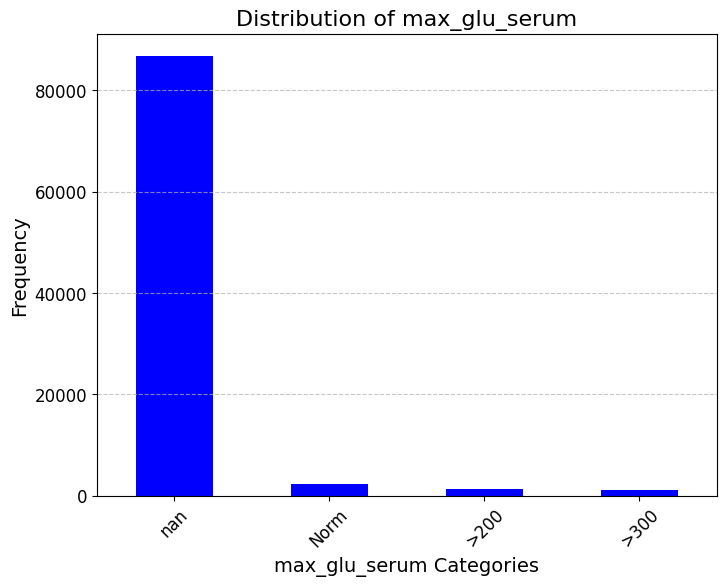

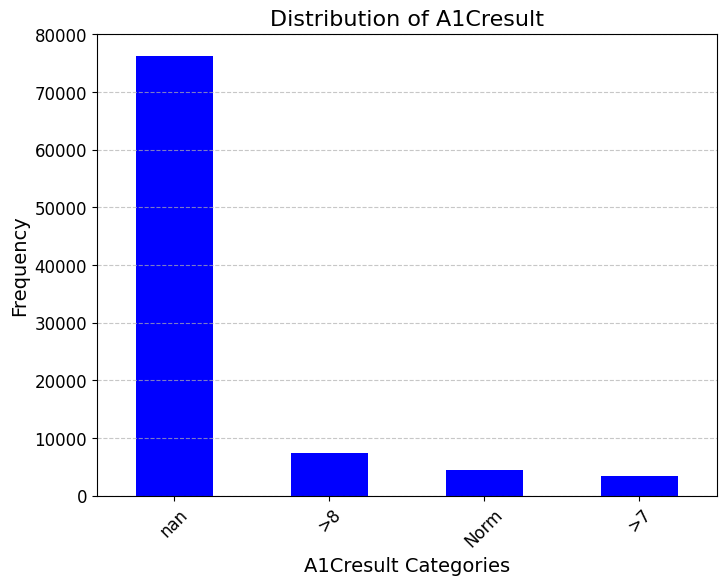

In [211]:
def plotBloodTestsDistribution():
    """
    Display the distribution of max_glu_serum and A1Cresult columns.
    """
columns = ['max_glu_serum', 'A1Cresult']

# Plot distributions for each column
for col in columns:
    if col in df_train.columns:
        plt.figure(figsize=(8, 6))
        df_train[col].value_counts(dropna=False).plot(kind='bar', color='blue')
        plt.title(f"Distribution of {col}", fontsize=16)
        plt.xlabel(f"{col} Categories", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

plotBloodTestsDistribution()

Chi-squared test is performed


In [212]:
# Extract all medication-related columns
medication_columns = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
    'glipizide-metformin', 'glimepiride-pioglitazone',
    'metformin-rosiglitazone', 'metformin-pioglitazone'
]

medication_df = df_train[medication_columns + ["readmitted"]]

# Perform X-squared test for independence on medication columns
def chi2_test(df, alpha=0.05):
    results = []  # To store test results for each medication column
    for col in df.columns:
        if col == "readmitted":  # Skip the target variable
            continue
        # Create contingency table
        contingency_table = pd.crosstab(df[col], df["readmitted"])

        # Perform chi-square test
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Append results
        results.append({
            "Medication": col,
            "Chi2 Statistic": chi2,
            "P-Value": p,
            "Degrees of Freedom": dof,
            "Significant": p < alpha  # Check if the result is statistically significant
        })

    # Convert results into a DataFrame
    results_df = pd.DataFrame(results)

    # print significant results count
    print(f"Number of significant results: {results_df['Significant'].sum()}")
    return results_df

chi2_test(medication_df)

Number of significant results: 8


,Medication,Chi2 Statistic,P-Value,Degrees of Freedom,Significant
0,metformin,101.149689,1.444219e-19,6,True
1,repaglinide,56.088802,2.793063e-10,6,True
2,nateglinide,4.248494,6.430883e-01,6,False
3,chlorpropamide,6.693907,1.529754e-01,4,False
4,glimepiride,13.106159,4.138077e-02,6,True
5,acetohexamide,1.863161,3.939307e-01,2,False
6,glipizide,47.933590,1.218274e-08,6,True
7,glyburide,7.415448,2.841283e-01,6,False
8,tolbutamide,1.281750,5.268312e-01,2,False
9,pioglitazone,26.729623,1.627067e-04,6,True


We can see that the combination medications have really high p-values (> 0.25), which means that they are not statistically significant.

In [213]:
# Define medication categories
categories = {
    'Biguanides': ['metformin'],
    'Meglitinides': ['repaglinide', 'nateglinide'],
    'Sulfonylureas': [
        'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
        'glyburide', 'tolbutamide', 'tolazamide', 'examide'
    ],
    'Thiazolidinediones (TZDs)': ['pioglitazone', 'rosiglitazone', 'troglitazone'],
    'Alpha-Glucosidase Inhibitors': ['acarbose', 'miglitol'],
    'Insulin': ['insulin'],
    'Combination Medications': [
        'glyburide-metformin', 'glipizide-metformin',
        'glimepiride-pioglitazone', 'metformin-rosiglitazone',
        'metformin-pioglitazone'
    ],
    'Miscellaneous': ['citoglipton']
}

non_combination_med_df = medication_df.copy()

for combination in categories["Combination Medications"]:
    first = combination.split('-')[0]
    second = combination.split('-')[1]


    non_combination_med_df.loc[medication_df[first] == "No", first] = medication_df[combination]
    non_combination_med_df.loc[medication_df[second] == "No", second] = medication_df[combination]

In [214]:
non_combination_med_df = non_combination_med_df.drop(columns=categories["Combination Medications"])
del categories["Combination Medications"]
chi2_test(non_combination_med_df)

Number of significant results: 8


,Medication,Chi2 Statistic,P-Value,Degrees of Freedom,Significant
0,metformin,101.149689,1.444219e-19,6,True
1,repaglinide,56.088802,2.793063e-10,6,True
2,nateglinide,4.248494,6.430883e-01,6,False
3,chlorpropamide,6.693907,1.529754e-01,4,False
4,glimepiride,13.106159,4.138077e-02,6,True
5,acetohexamide,1.863161,3.939307e-01,2,False
6,glipizide,48.177706,1.088843e-08,6,True
7,glyburide,7.256668,2.977616e-01,6,False
8,tolbutamide,1.281750,5.268312e-01,2,False
9,pioglitazone,26.729623,1.627067e-04,6,True


After removing the combination medications, we can see that some p-values are lower, such as glipizide. However, it still not change the total number of significant features.

In [215]:
# Create features that capture the temporal aspects of medication changes
def create_temporal_features(df):
    # Count increases and decreases separately
    increases = df[medication_columns].apply(
        lambda x: sum(1 for val in x if val == 'Up'), axis=1)
    decreases = df[medication_columns].apply(
        lambda x: sum(1 for val in x if val == 'Down'), axis=1)
    
    # Calculate total dose changes 
    df['total_dose_changes'] = increases - decreases
    
    # Calculate ratio that distinguishes between zero types
    df['dose_change_ratio'] = df.apply(
        lambda row: (
            0 if increases[row.name] == 0 and decreases[row.name] == 0  # No changes
            else 0.5 if increases[row.name] == decreases[row.name]      # Equal ups/downs
            else increases[row.name] - decreases[row.name]        
                                                           
        ), axis=1)
    
    return df

create_temporal_features(df_train)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,total_dose_changes,dose_change_ratio
0,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,No,No,No,No,Ch,Yes,>30,1,1.0
1,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,Yes,NO,0,0.0
2,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,No,No,No,No,Ch,Yes,NO,1,1.0
3,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,No,No,No,No,Ch,Yes,NO,0,0.0
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,No,No,No,No,No,Yes,>30,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91584,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,No,No,No,No,Ch,Yes,>30,-1,-1.0
91585,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,No,No,No,No,No,Yes,NO,0,0.0
91586,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,No,No,No,No,Ch,Yes,NO,-1,-1.0
91587,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,No,No,No,No,Ch,Yes,NO,1,1.0


dose_change_ratio: new features that distinguishes between no changes, balanced adjustments and imbalanced dose modifications. This feature highlights treatment trends that may indicate patient stability or worsening conditions, such as frequent or highly imbalanced dose changes.

## Feature Selection section:

In [216]:
# Missing values are represented as '?' or 'Unknown/Invalid' in the dataset

def missing_data_summary(df):
    # Missing data check - ?
    missing_data_question = df.isin(['?']).sum()
    missing_data_question = missing_data_question[missing_data_question > 0].sort_values(ascending=False)
    missing_data_question_percentage = (missing_data_question / len(df)) * 100
    print("\nMissing data - '?':\n")
    print(pd.DataFrame({
        'Missing Count': missing_data_question,
        'Missing Percentage': missing_data_question_percentage
    }).sort_values(by='Missing Count', ascending=False))

    # Missing data check - Unknown/Invalid
    missing_data_unknown = df.isin(['Unknown/Invalid']).sum()
    missing_data_unknown = missing_data_unknown[missing_data_unknown > 0].sort_values(ascending=False)
    missing_data_unknown_percentage = (missing_data_unknown / len(df)) * 100
    print("\nMissing data - 'Unknown/Invalid':\n")
    print(pd.DataFrame({
        'Missing Count': missing_data_unknown,
        'Missing Percentage': missing_data_unknown_percentage
    }).sort_values(by='Missing Count', ascending=False))


missing_data_summary(df_train)



Missing data - '?':

                   Missing Count  Missing Percentage
weight                     88754           96.904650
medical_specialty          44992           49.123803
payer_code                 36247           39.575713
race                        2059            2.248087
diag_3                      1266            1.382262
diag_2                       320            0.349387
diag_1                        21            0.022929

Missing data - 'Unknown/Invalid':

        Missing Count  Missing Percentage
gender              3            0.003276


Features with substantial missing values, such as ’weight’ (96.9% missing) and ’medical specialty’ (49.1% missing), were excluded to improve the dataset’s robustness.

## Preprocess Pipeline 

The pipeline defines our feature engineering including:
- Drop rows and columns
- Handle Missing Values
- Encoding Fetures
- Feature Selection
- Data Exploration

In [6]:
preprocess_pipeline = Pipeline([
    # Drop rows and columns
    ('admission_type', AdmissionTypeTransformer(column="admission_type_id")),
    ('discharge_disposition', DischargeDispositionTransformer(column="discharge_disposition_id")),
    ('drop_samples', DropRowsTransformer(conditions=[
        lambda df: df["admission_type_id"] == 2,                                # drop patients with newbown
        lambda df: df["discharge_disposition_id"] == 1,                         # drop patients hospice
        lambda df: df["discharge_disposition_id"] == 8                          # drop patients expired
    ])),
    ('readmitted', ReadmittedTransformer(column="readmitted")),
    ('collapse_duplicates', CollapseDuplicatedPatientsTransformer()),
    ('create utilization', CreateUtilizationTransformer()),
    #('drop_columns', DropColumnsTransformer(columns_to_drop=["weight", "medical_specialty", "payer_code", "encounter_id", "patient_nbr"])),  # Drop unnecessary columns
    ('drop_columns', DropColumnsTransformer(columns_to_drop=["weight", "payer_code", "encounter_id", "patient_nbr", "medical_specialty", 
                                                             "number_inpatient","number_outpatient","number_emergency"])),  # Drop unnecessary columns
    ("Remove Outliers", RemoveOutliersTransformer(columns=['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses'])),

    # Encoding

    # Encode race
    ('encode_race', EncodeRaceImputationTransformer(column="race")),
    #('encode_race', EncodeRaceTransformer(column="race")),                         

    # Encode gender
    ('encode_gender', EncodeGenderImputationTransformer(column="gender")),
    #('encode_gender', EncodeGenderTransformer(column="gender")),                   

    
    ('encode_age', EncodeAgeTransformer(column="age")),  # Encode age                          
    ('admission_source', AdmissionSourceTransformer(column="admission_source_id")), # Map admission source

    # Process diagnosis columns
    ('diagnosis', DiagnosisNoOneHotTransformer(columns=["diag_1", "diag_2", "diag_3"])),  
    #('diagnosis', DiagnosisTransformer(diag_columns=["diag_1", "diag_2", "diag_3"], threshold=3.0)),

    #('medical_specialty', MedicalSepcialtyTransformer(column="medical_specialty")),
    ('max_glu_serum', MaxGluSerumTransformer(column="max_glu_serum")),             # Encode max_glu_serum
    ('a1c_result', A1CResultTransformer(column="A1Cresult")),                      # Encode A1C result
    ('medicines', MedicinesTransformer()),                                         # Group medication and create features
    ('change', ChangeTransformer(column="change")),                                # Encode change
    ('diabetes_med', DiabetesMedTransformer(column="diabetesMed")),                # Encode diabetes medication
    
    #('imputer', ModelImputationTransformer(target_features=["race","gender"])),
    ('imputer', ModelImputationTransformer(target_features=["race","gender","diag_1","diag_2","diag_3"])),            

    # Feature Selection and Visualization
    ('feature selection1', CorrelationSelector(visualization=True)),
    ('feature selection2', LassoFeatureSelector(visualization=True)),
    #('feature selection3', RFEFeatureSelector(visualization=False)),

    # ('Scaler', StandardScaler()), # StandardScaler
    # ('PCA', PCA(n_components=20)) # PCA
])

# NOTE: This pipeline only be used for other novel tries, its not used in main project
preprocess_pipeline_2model = Pipeline([
    # Drop rows and columns
    ('admission_type', AdmissionTypeTransformer(column="admission_type_id")),
    ('discharge_disposition', DischargeDispositionTransformer(column="discharge_disposition_id")),
    ('drop_samples', DropRowsTransformer(conditions=[
        lambda df: df["admission_type_id"] == 2,                                # drop patients with newbown
        lambda df: df["discharge_disposition_id"] == 1,                         # drop patients hospice
        lambda df: df["discharge_disposition_id"] == 8                          # drop patients expired
    ])),
    ('readmitted', ReadmittedTransformer_2models(column="readmitted")),
    ('collapse_duplicates', CollapseDuplicatedPatientsTransformer()),

    #('drop_columns', DropColumnsTransformer(columns_to_drop=["weight", "medical_specialty", "payer_code", "encounter_id", "patient_nbr"])),  # Drop unnecessary columns
    ('drop_columns', DropColumnsTransformer(columns_to_drop=["weight", "payer_code", "encounter_id", "patient_nbr"])),  # Drop unnecessary columns

    # Encoding

    # Encode race
    ('encode_race', EncodeRaceImputationTransformer(column="race")),
    #('encode_race', EncodeRaceTransformer(column="race")),

    # Encode gender
    ('encode_gender', EncodeGenderImputationTransformer(column="gender")),
    #('encode_gender', EncodeGenderTransformer(column="gender")),


    ('encode_age', EncodeAgeTransformer(column="age")),  # Encode age
    ('admission_source', AdmissionSourceTransformer(column="admission_source_id")), # Map admission source

    # Process diagnosis columns
    ('diagnosis', DiagnosisNoOneHotTransformer(columns=["diag_1", "diag_2", "diag_3"])),
    #('diagnosis', DiagnosisTransformer(diag_columns=["diag_1", "diag_2", "diag_3"], threshold=3.0)),

    ('medical_specialty', MedicalSepcialtyTransformer(column="medical_specialty")),
    ('max_glu_serum', MaxGluSerumTransformer(column="max_glu_serum")),             # Encode max_glu_serum
    ('a1c_result', A1CResultTransformer(column="A1Cresult")),                      # Encode A1C result
    ('medicines', MedicinesTransformer()),                                         # Group medication and create features
    ('change', ChangeTransformer(column="change")),                                # Encode change
    ('diabetes_med', DiabetesMedTransformer(column="diabetesMed")),                # Encode diabetes medication

    #('imputer', ModelImputationTransformer(target_features=["race","gender"])),
    ('imputer', ModelImputationTransformer(target_features=["race","gender","diag_1","diag_2","diag_3"])),

    # Feature Selection and Visualization
    ('feature selection1', CorrelationSelector(visualization=True)),
    ('feature selection2', LassoFeatureSelector(visualization=True)),
    #('feature selection3', RFEFeatureSelector(visualization=False)),

    # ('Scaler', StandardScaler()), # StandardScaler
    # ('PCA', PCA(n_components=20)) # PCA
])

* The correlation matrix above identified redundant features, notably ’dose_change_ratio’, which needs to be removed due to its high correlation with other variables.

* Lasso Feature Selector method utilizes Lasso (Least Absolute Shrinkage and Selection Operator) regularization to determine the significance of features by penalizing the absolute size of the regression coefficients.
* Features with coefficients have shrink to near zero, such as ‘change’, ‘Digestive’, ‘Musculoskeletal’, ‘Other’, ‘Meglitinides’ and ‘Alpha-Glucosidase Inhibitors’, can be seen as insignificant and removed. 
* This will help us fine-tuning our predictive model by only keeping those features that provide meaningful information for outcome prediction.

# 4. Methodology Overview

## Data Imputation and Resampling section:

In [ ]:
class ModelImputationTransformer(BaseEstimator, TransformerMixin):
    """
    A custom transformer that uses a multi-output model (e.g., MultiOutputClassifier)
    to impute missing values for specified target columns.
    """

    def __init__(self, target_features=None, base_model=None):
        """
        :param target_features: list[str], the names of the columns to be imputed.
        :param base_model: The classifier (or regressor) to be used. 
                          Defaults to MultiOutputClassifier(LogisticRegression()).
        """
        self.target_features = target_features or []
        self.base_model = base_model or MultiOutputClassifier(LogisticRegression())
        self.input_features_ = None  # Will be inferred at fit time
        self.fitted_model_ = None

    def fit(self, X, y=None):
        """
        In the fit phase, select rows where the target_features are not missing
        and use them to train the model.
        """
        # 1) Copy X to avoid modifying it in place
        df = X.copy()
        # 2) Input features = all columns in X that are not in target_features
        #    (Assuming target_features exist in X)
        self.input_features_ = [col for col in df.columns if col not in self.target_features]
        # 3) Filter rows where all target_features are non-missing (for training)
        train_data = df.dropna(subset=self.target_features)
        X_train = train_data[self.input_features_]
        y_train = train_data[self.target_features]
        # 4) Train the multi-output model
        self.base_model.fit(X_train, y_train)
        self.fitted_model_ = self.base_model  # Store the trained model for use in transform

        return self

    def transform(self, X):
        """
        In the transform phase, use the trained model to predict and fill in 
        missing values for the target_features.
        """
        if self.fitted_model_ is None:
            # If transform is called before fit, choose to either return X or raise an error
            return X  

        df = X.copy()
        # 1) Identify rows where any of the target_features are missing
        missing_mask = df[self.target_features].isna().any(axis=1)
        test_data = df[missing_mask]

        # 2) If there are no missing values, simply return df
        if test_data.empty:
            return df
        
        # 3) Predict values for rows with missing data
        X_test = test_data[self.input_features_]
        y_pred = self.fitted_model_.predict(X_test)

        # 4) Fill in the predicted values
        for idx, col in enumerate(self.target_features):
            # Find rows where the current column is missing
            col_nan_mask = test_data[col].isna()
            # Assign the predicted values to those rows
            test_data.loc[col_nan_mask, col] = y_pred[col_nan_mask, idx]

        # 5) Update df with the newly imputed values
        df.loc[missing_mask, self.target_features] = test_data[self.target_features]
        return df


* Several important features such as race, gender, diag_1, diag_2, and diag_3 show missing data
* We created a custom solution using a MultiOutputClassifier with Logistic Regression to address it. 
* This approach allowed the model to infer missing values effectively by identifying patterns and learning the underlying distribution in the non-missing data, preserving the dataset’s integrity.

------------------------------------------------------------------------------------------------

## 5 and 6. Model Training & Validation with Results

### BaseLine Model without feature engineering
keep a simple working flow, just use a easy LabelEncoder

In [4]:
categorical_features = [
    'race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty',
   'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
   'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
   'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
   'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
   'tolazamide', 'examide', 'citoglipton', 'insulin',
   'glyburide-metformin', 'glipizide-metformin',
   'glimepiride-pioglitazone', 'metformin-rosiglitazone',
   'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']

label_encoders = {}
models = ["logistic_regression","naive_bayes","random_forest","xgboost","lightgbm"]
encoded_df = df_train.fillna("missing")
for feature in categorical_features:
    label_encoder = LabelEncoder()
    encoded_df[feature] = label_encoder.fit_transform(encoded_df[feature])
    label_encoders[feature] = label_encoder

X_train = encoded_df.drop(columns=['readmitted'])
y_train = encoded_df['readmitted']

# Encode known categories, and fallback to -1 for unknown labels
def safe_transform(encoder, series):
    known_classes = list(encoder.classes_)
    return series.apply(lambda x: encoder.transform([x])[0] if x in known_classes else -1)

encoded_df = df_test.fillna("missing")
for feature in categorical_features:
    label_encoder = label_encoders[feature]
    encoded_df[feature] = safe_transform(label_encoder, encoded_df[feature])

### Logistic - Base

           Metric     Value
0  F1 Score Macro  0.285483
1    Recall Macro  0.345351
2           PRAUC  0.365290
3     Final Score  0.332041


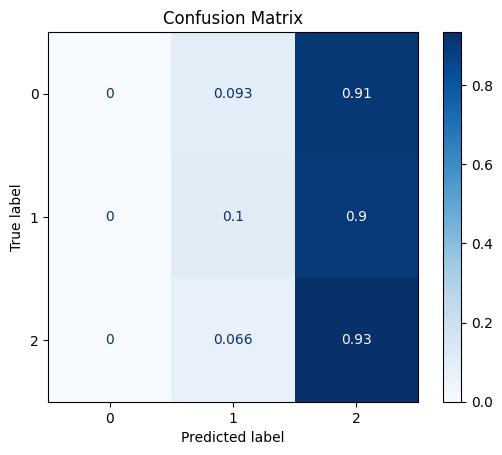

In [10]:
model = LogisticRegression()
evaluate_base(model, X_train, y_train)

### Naive Bayes - Base

           Metric     Value
0  F1 Score Macro  0.233450
1    Recall Macro  0.333333
2           PRAUC  0.378200
3     Final Score  0.314994


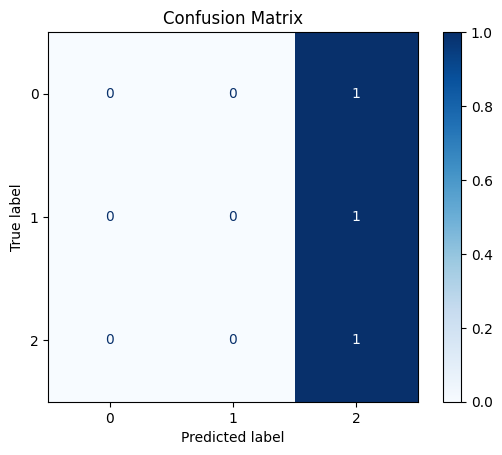

In [11]:
model = GaussianNB()
evaluate_base(model, X_train, y_train)

### Random Forest - Base

           Metric     Value
0  F1 Score Macro  0.416017
1    Recall Macro  0.432159
2           PRAUC  0.487191
3     Final Score  0.445122


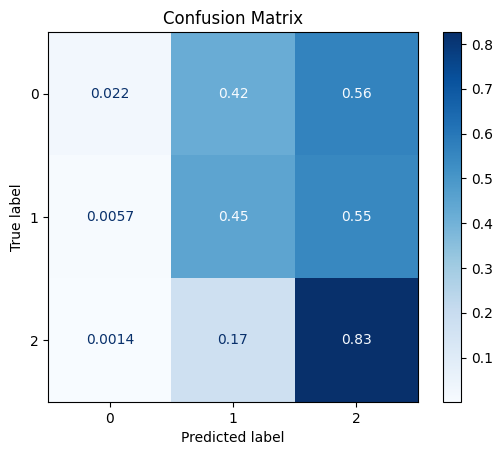

In [12]:
model = RandomForestClassifier()
evaluate_base(model, X_train, y_train)

### XGBoost - Base

           Metric     Value
0  F1 Score Macro  0.446714
1    Recall Macro  0.453150
2           PRAUC  0.509546
3     Final Score  0.469803


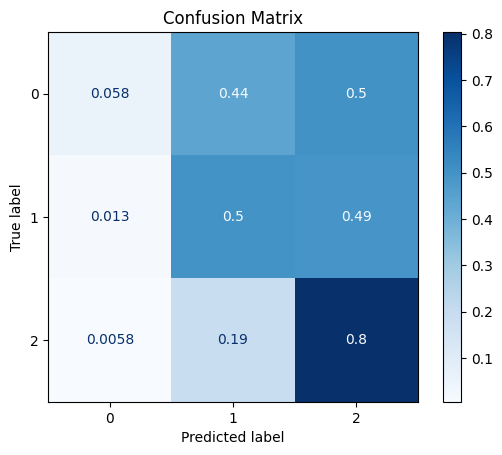

In [13]:
model = XGBClassifier()
evaluate_base(model, X_train, y_train)

### LightGBM - Base

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1706
[LightGBM] [Info] Number of data points in the train set: 73271, number of used features: 40
[LightGBM] [Info] Start training from score -2.196761
[LightGBM] [Info] Start training from score -1.050753
[LightGBM] [Info] Start training from score -0.617738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1698
[LightGBM] [Info] Number of data points in the train set: 73271, number of used features: 39
[LightGBM] [Info] Start training from score -2.182982
[LightGBM] [Info] Start training from score -1.054271
[LightGBM] [Info] Start 

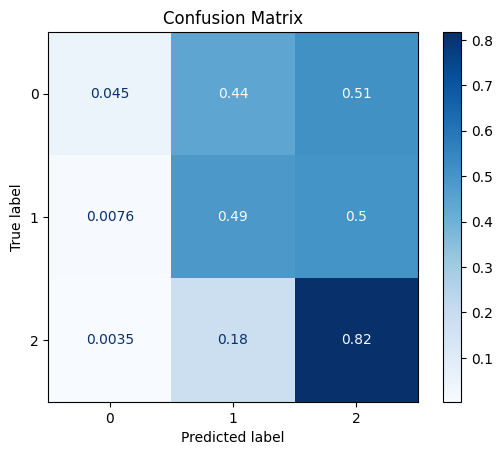

In [14]:
model = LGBMClassifier()
evaluate_base(model, X_train, y_train)

## Model Selection

In [ ]:
# Redefine training dataset with designed feature engineering
preprocessed_train_df = preprocess_pipeline.fit_transform(df_train)
X_train = preprocessed_train_df.drop(columns=['readmitted'])
X_train = X_train[sorted(X_train)]
y_train = preprocessed_train_df['readmitted']

preprocessed_test_df = preprocess_pipeline.transform(df_test)
X_test = preprocessed_test_df.drop(columns=['readmitted'])
X_test = X_test[sorted(X_test)]
y_test = preprocessed_test_df['readmitted']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

First split to 5-fold validation dataset

In [11]:
methods = ["no","gmm","smote", "undersampling", "stk"]
sampled_data = {method: [] for method in methods} 
#methods = ["no","undersampling"]
kf = KFold(n_splits=5, shuffle=True, random_state=42)
data = []
for train_idx, val_idx in kf.split(X_train, y_train):
  X_train_val, X_val = X_train[train_idx], X_train[val_idx]
  y_train_val, y_val = y_train[train_idx], y_train[val_idx]
  sampling_result = sampling(X_train_val, y_train_val, methods=methods)
  data.append({"Sampled":sampling_result, "Validation":(X_val, y_val)})

Resample our original dataset

In [12]:
resampled_training_dataset = sampling(X_train, y_train, methods=methods)

### Logistic Regression

no
           Metric     Value
0  F1 Score Macro  0.489476
1    Recall Macro  0.504939
2           PRAUC  0.576052
3     Final Score  0.523489


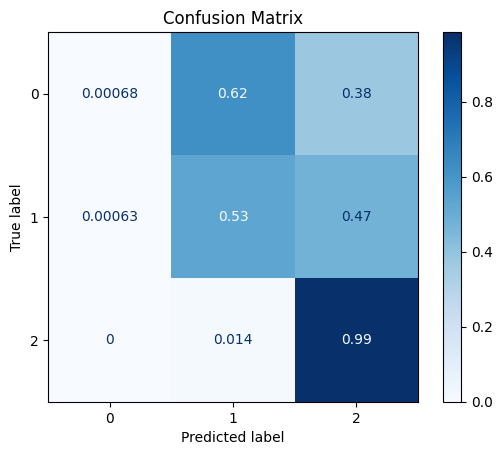

gmm
           Metric     Value
0  F1 Score Macro  0.504130
1    Recall Macro  0.535133
2           PRAUC  0.546471
3     Final Score  0.528578


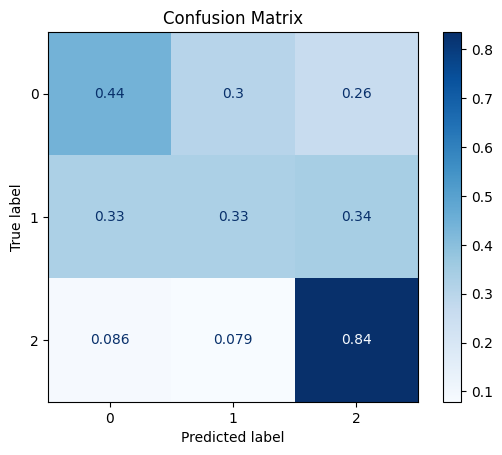

smote
           Metric     Value
0  F1 Score Macro  0.519038
1    Recall Macro  0.543656
2           PRAUC  0.572651
3     Final Score  0.545115


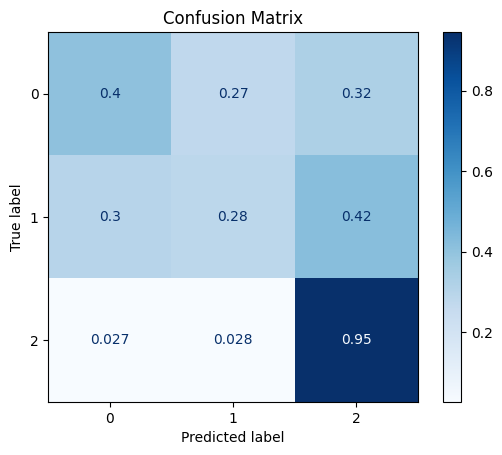

undersampling
           Metric     Value
0  F1 Score Macro  0.521660
1    Recall Macro  0.544224
2           PRAUC  0.572454
3     Final Score  0.546113


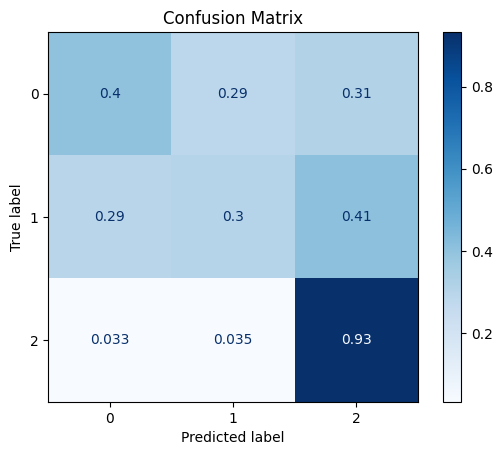

stk
           Metric     Value
0  F1 Score Macro  0.514323
1    Recall Macro  0.544459
2           PRAUC  0.573171
3     Final Score  0.543984


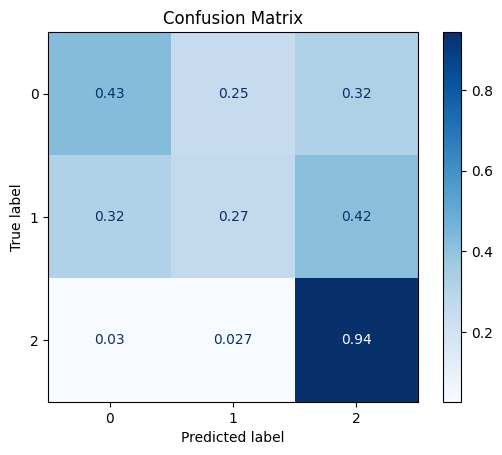

In [120]:
logistic_model = {}
save_path = "./models/logistic/"
os.makedirs(save_path, exist_ok=True)
for sample_method in methods:
    print("="*50)
    print(sample_method)
    # extract certain sampling method data
    # Hyperparameter tuning
    X_train_resampled, y_train_resampled = resampled_training_dataset[sample_method]
    study = optuna.create_study(direction='maximize')
    study.optimize(
        lambda trial: objective(
            trial=trial,
            data = data,
            sample_method=sample_method,
            classifier_name='logistic_regression'
        ),
        n_trials=10
    )
    best_trial = study.best_trial
    best_params = best_trial.params
    visualize_result(best_trial)
    model = LogisticRegression(**best_params)
    model.fit(X_train_resampled, y_train_resampled)
    joblib.dump(model, os.path.join(save_path, f"{sample_method}.pkl"))
    logistic_model[sample_method] = model

### Naive Bayes

no
           Metric     Value
0  F1 Score Macro  0.508459
1    Recall Macro  0.508181
2           PRAUC  0.559669
3     Final Score  0.525436


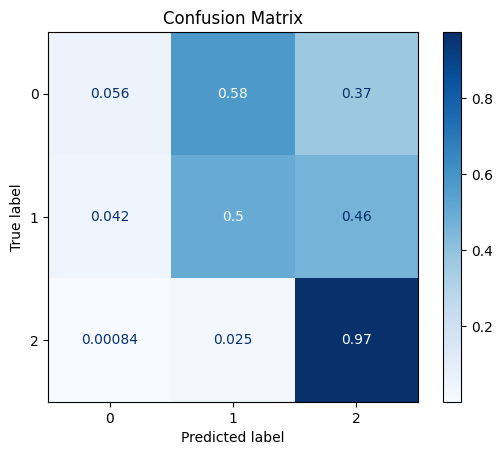

gmm
           Metric     Value
0  F1 Score Macro  0.525270
1    Recall Macro  0.532460
2           PRAUC  0.553088
3     Final Score  0.536939


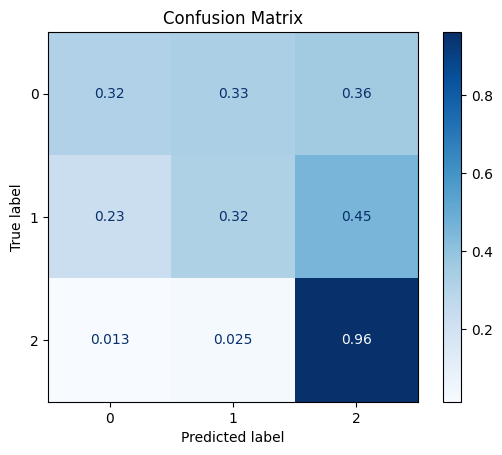

smote
           Metric     Value
0  F1 Score Macro  0.512755
1    Recall Macro  0.530047
2           PRAUC  0.548121
3     Final Score  0.530308


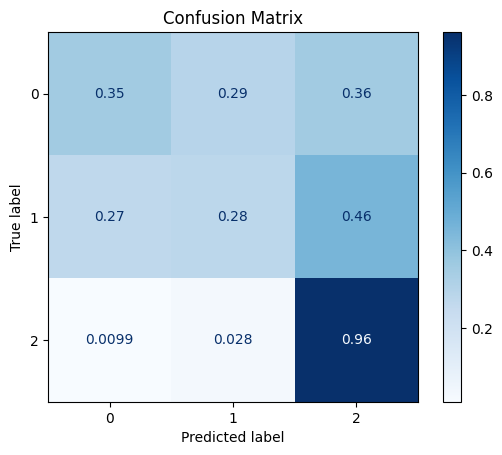

undersampling
           Metric     Value
0  F1 Score Macro  0.523694
1    Recall Macro  0.533807
2           PRAUC  0.550875
3     Final Score  0.536125


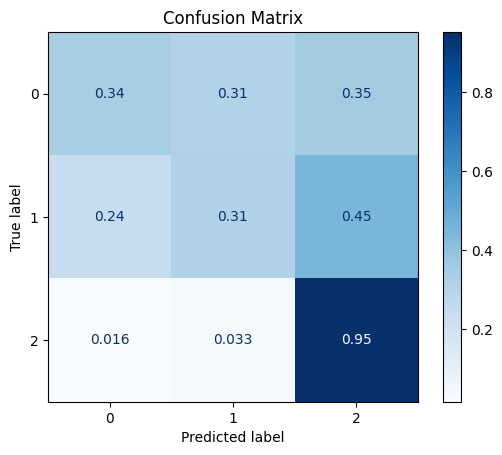

stk
           Metric     Value
0  F1 Score Macro  0.511080
1    Recall Macro  0.530510
2           PRAUC  0.547743
3     Final Score  0.529778


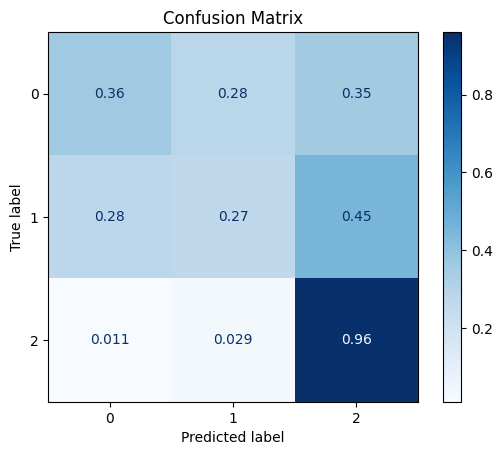

In [123]:
logistic_model = {}
save_path = "./models/naive_bayes/"
os.makedirs(save_path, exist_ok=True)
for sample_method in methods:
    print("="*50)
    print(sample_method)
    # extract certain sampling method data
    # Hyperparameter tuning
    X_train_resampled, y_train_resampled = resampled_training_dataset[sample_method]
    study = optuna.create_study(direction='maximize')
    study.optimize(
        lambda trial: objective(
            trial=trial,
            data = data,
            sample_method=sample_method,
            classifier_name='naive_bayes'
        ),
        n_trials=10
    )
    best_trial = study.best_trial
    best_params = best_trial.params
    visualize_result(best_trial)

    model = GaussianNB(**best_params)
    model.fit(X_train_resampled, y_train_resampled)
    joblib.dump(model, os.path.join(save_path, f"{sample_method}.pkl"))
    logistic_model[sample_method] = model

### Random Forest

no
           Metric     Value
0  F1 Score Macro  0.500693
1    Recall Macro  0.511913
2           PRAUC  0.593373
3     Final Score  0.535326


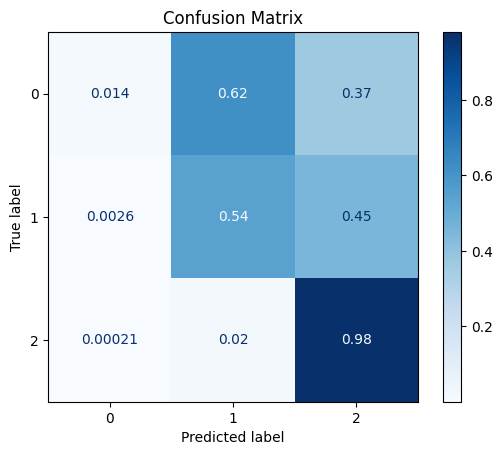

gmm
           Metric     Value
0  F1 Score Macro  0.492194
1    Recall Macro  0.505714
2           PRAUC  0.598333
3     Final Score  0.532080


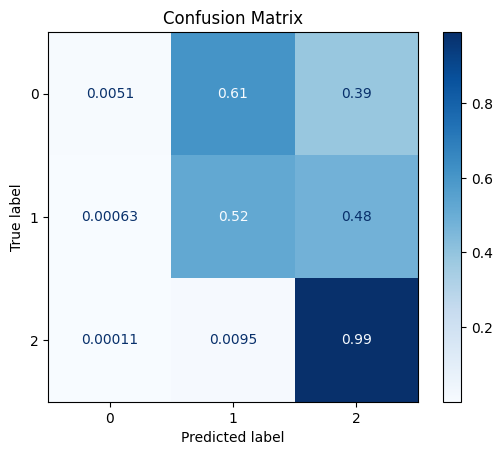

smote
           Metric     Value
0  F1 Score Macro  0.555306
1    Recall Macro  0.540987
2           PRAUC  0.590569
3     Final Score  0.562287


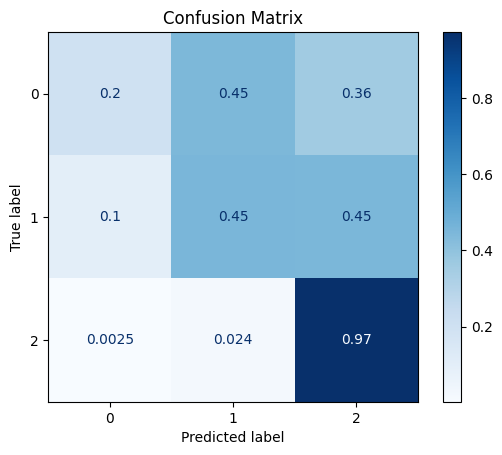

undersampling
           Metric     Value
0  F1 Score Macro  0.526824
1    Recall Macro  0.560508
2           PRAUC  0.586278
3     Final Score  0.557870


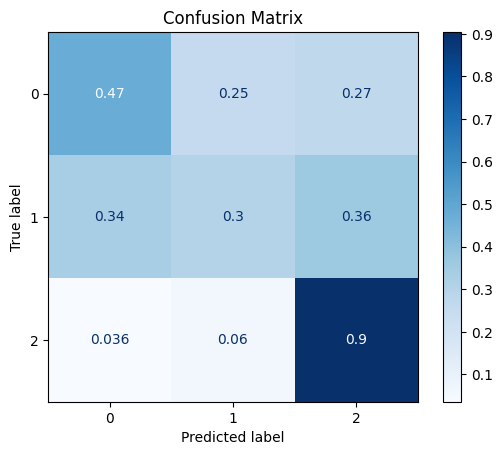

stk
           Metric     Value
0  F1 Score Macro  0.554427
1    Recall Macro  0.541550
2           PRAUC  0.588315
3     Final Score  0.561431


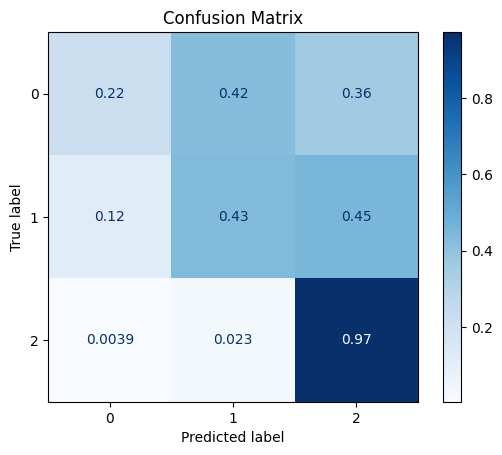

In [124]:
logistic_model = {}
save_path = "./models/random_forest/"
os.makedirs(save_path, exist_ok=True)
for sample_method in methods:
    print("="*50)
    print(sample_method)
    # extract certain sampling method data
    # Hyperparameter tuning
    X_train_resampled, y_train_resampled = resampled_training_dataset[sample_method]
    study = optuna.create_study(direction='maximize')
    study.optimize(
        lambda trial: objective(
            trial=trial,
            data = data,
            sample_method=sample_method,
            classifier_name='random_forest'
        ),
        n_trials=5
    )
    best_trial = study.best_trial
    best_params = best_trial.params
    visualize_result(best_trial)

    model = RandomForestClassifier(**best_params)
    model.fit(X_train_resampled, y_train_resampled)
    joblib.dump(model, os.path.join(save_path, f"{sample_method}.pkl"))
    logistic_model[sample_method] = model

### XGBoost

no
           Metric     Value
0  F1 Score Macro  0.523428
1    Recall Macro  0.523637
2           PRAUC  0.597846
3     Final Score  0.548304


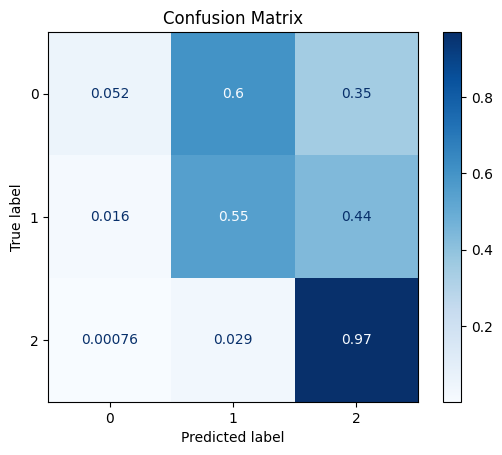

gmm
           Metric     Value
0  F1 Score Macro  0.517799
1    Recall Macro  0.520818
2           PRAUC  0.603736
3     Final Score  0.547451


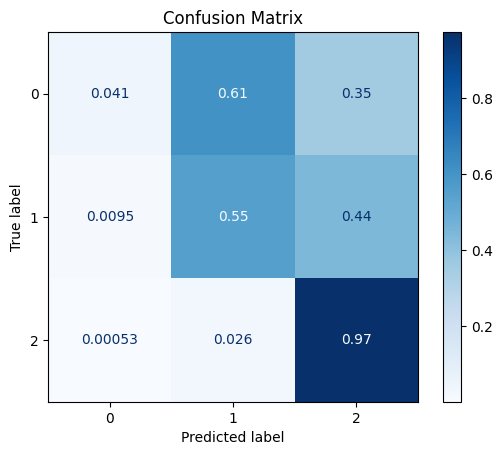

smote
           Metric     Value
0  F1 Score Macro  0.537392
1    Recall Macro  0.529478
2           PRAUC  0.597798
3     Final Score  0.554890


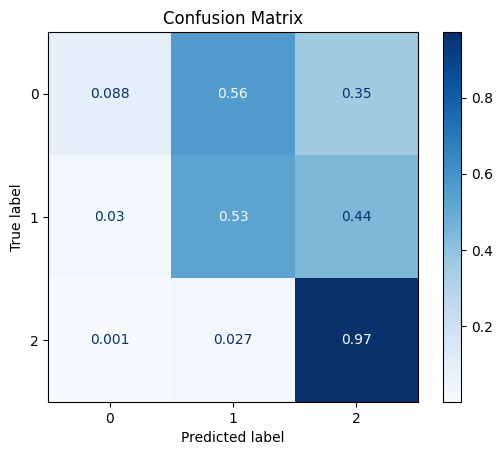

undersampling
           Metric     Value
0  F1 Score Macro  0.533067
1    Recall Macro  0.563795
2           PRAUC  0.588340
3     Final Score  0.561734


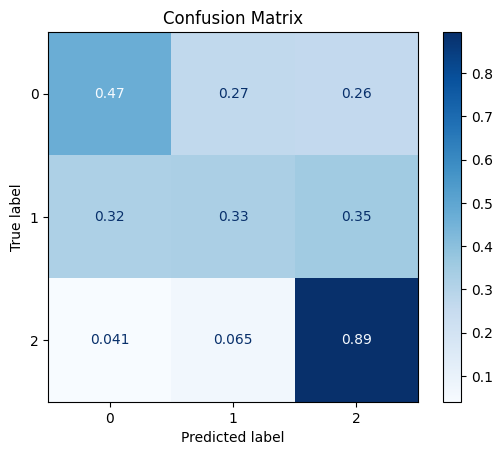

stk
           Metric     Value
0  F1 Score Macro  0.544137
1    Recall Macro  0.531906
2           PRAUC  0.593439
3     Final Score  0.556494


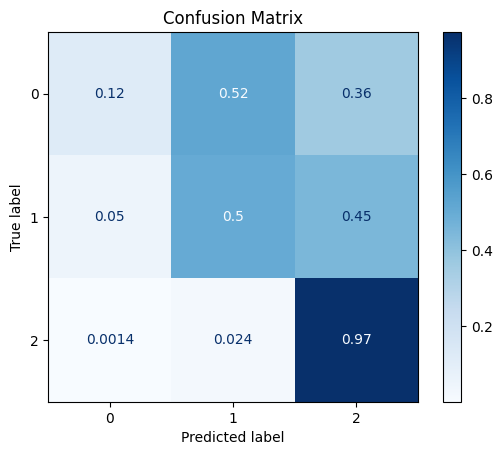

In [126]:
xgboost_model = {}
save_path = "./models/xgboost/"
os.makedirs(save_path, exist_ok=True)
for sample_method in methods:
    print("="*50)
    print(sample_method)
    # extract certain sampling method data
    # Hyperparameter tuning
    X_train_resampled, y_train_resampled = resampled_training_dataset[sample_method]
    study = optuna.create_study(direction='maximize')
    study.optimize(
        lambda trial: objective(
            trial=trial,
            data = data,
            sample_method=sample_method,
            classifier_name='xgboost'
        ),
        n_trials=5
    )
    best_trial = study.best_trial
    best_params = best_trial.params
    visualize_result(best_trial)

    model = XGBClassifier(**best_params)
    model.fit(X_train_resampled, y_train_resampled)
    joblib.dump(model, os.path.join(save_path, f"{sample_method}.pkl"))
    xgboost_model[sample_method] = model

### LightBGM

In [ ]:
lightbgm_model = {}
save_path = "./models/lightbgm/"
os.makedirs(save_path, exist_ok=True)
for sample_method in methods:
    print("="*50)
    print(sample_method)
    # extract certain sampling method data
    # Hyperparameter tuning
    X_train_resampled, y_train_resampled = resampled_training_dataset[sample_method]
    study = optuna.create_study(direction='maximize')
    study.optimize(
        lambda trial: objective(
            trial=trial,
            data = data,
            sample_method=sample_method,
            classifier_name='lightgbm'
        ),
        n_trials=5
    )
    best_trial = study.best_trial
    best_params = best_trial.params
    visualize_result(best_trial)

    model = LGBMClassifier(**best_params)
    model.fit(X_train_resampled, y_train_resampled)
    joblib.dump(model, os.path.join(save_path, f"{sample_method}.pkl"))
    lightbgm_model[sample_method] = model

no


## 7. Final Predictions on Test Set
Start to evaluate our best model on testing dataset. Based on the best final score above, we decied to chhoose XGBoost model trained by Undersampling dataset

load best model

In [38]:
best_model = joblib.load('./models/xgboost/undersampling.pkl')

apply it on testing dataset and evaluation

F1 Score (Macro): 0.4156862629163989
Recall (Macro): 0.430778922003163
PR AUC (Macro): 0.4608078947087029
Final Score: 0.4357576932094216

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.23      0.22      1000
           1       0.52      0.23      0.32      3288
           2       0.62      0.83      0.71      5097

    accuracy                           0.56      9385
   macro avg       0.45      0.43      0.42      9385
weighted avg       0.54      0.56      0.52      9385



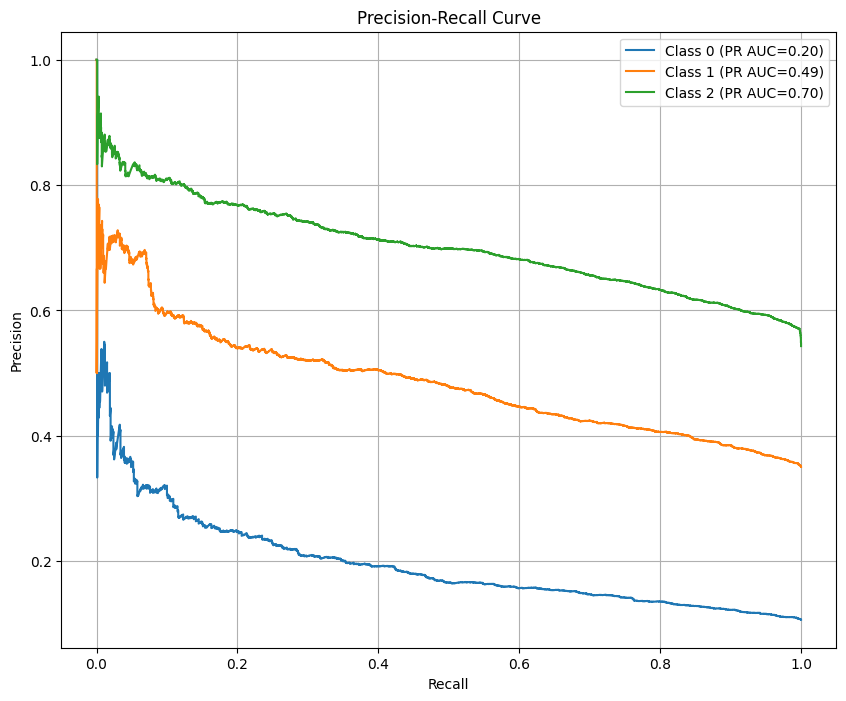

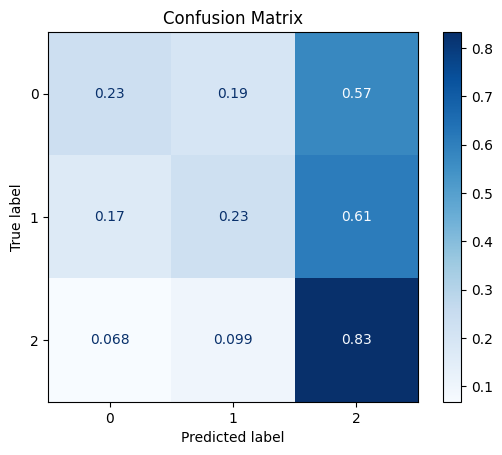

In [39]:
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

n_classes = len(set(y_test))
pr_auc_scores = []

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    y_true_binary = (y_test == i).astype(int)
    precision, recall_curve, _ = precision_recall_curve(y_true_binary, y_pred_prob[:, i])
    pr_auc = auc(recall_curve, precision)  # 计算 PR AUC
    pr_auc_scores.append(pr_auc)
    plt.plot(recall_curve, precision, label=f'Class {i} (PR AUC={pr_auc:.2f})')

pr_auc_macro = np.mean(pr_auc_scores)
final_score = (f1 + recall + pr_auc_macro) / 3
# print result
print("F1 Score (Macro):", f1)
print("Recall (Macro):", recall)
print("PR AUC (Macro):", pr_auc_macro)
print("Final Score:", final_score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# plot PR curve
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

# visualize confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


## Other Novel Tries

### Use two models
- the first model classify the "not readmitted"(NO) and "readmitted"(<30,>30)
- the second model classify the ">30" and "<30" from model1 "readmitted" result  

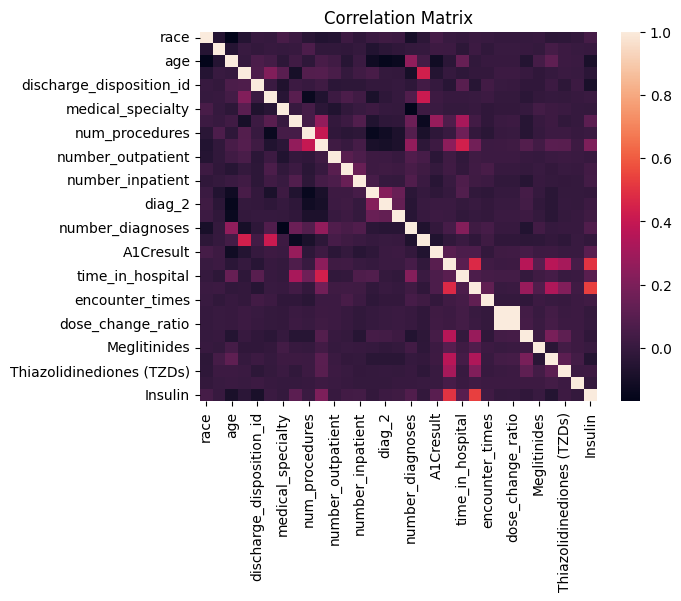

features ned to be removed from correlation ['dose_change_ratio']


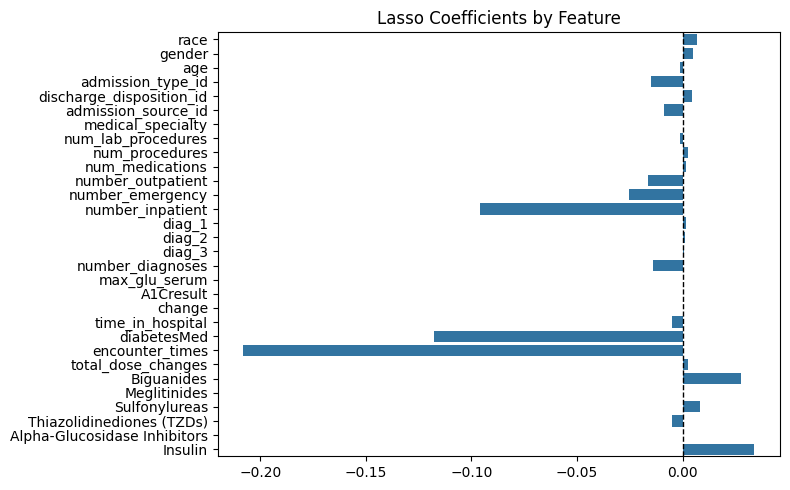

Features to remove based on LASSO: ['change', 'Meglitinides', 'Alpha-Glucosidase Inhibitors']


In [17]:
preprocessed_train_df_2class = preprocess_pipeline_2model.fit_transform(df_train)
X_train_2class = preprocessed_train_df_2class.drop(columns=['readmitted'])
y_train_2class = preprocessed_train_df_2class['readmitted']

preprocessed_test_df_2class = preprocess_pipeline_2model.transform(df_test)
X_test_2class = preprocessed_test_df_2class.drop(columns=['readmitted'])
y_test_2class = preprocessed_test_df_2class['readmitted']

In [18]:
classifier01 = RandomForestClassifier(
                n_estimators=100,
                max_depth=30,
                min_samples_split=10,
                min_samples_leaf=5,
                random_state=42,
                class_weight={0:1,1:4}
                )
classifier01.fit(X_train_2class, y_train_2class)
predictions = classifier01.predict(X_test_2class)

# Find the indices where the predicted label is 0 in the test set
indices_predicted_0 = np.where(predictions == 0)[0]

print("Final Test Accuracy:", accuracy_score(y_test_2class, predictions))
print("Final Balanced Accuracy:", balanced_accuracy_score(y_test_2class, predictions))
print("Final Test Classification Report:\n", classification_report(y_test_2class, predictions))
#plot_multiclass_roc(X_test, y_test, [0,1,2], classifier)

# Count the number of predictions for each class
unique, counts = np.unique(predictions, return_counts=True)
predictions_count = pd.DataFrame({'Class': unique, 'Count': counts})

print(predictions_count)

Final Test Accuracy: 0.5982951518380394
Final Balanced Accuracy: 0.5609933612543522
Final Test Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.13      0.23      4288
           1       0.58      0.99      0.73      5097

    accuracy                           0.60      9385
   macro avg       0.76      0.56      0.48      9385
weighted avg       0.74      0.60      0.50      9385

   Class  Count
0      0    582
1      1   8803


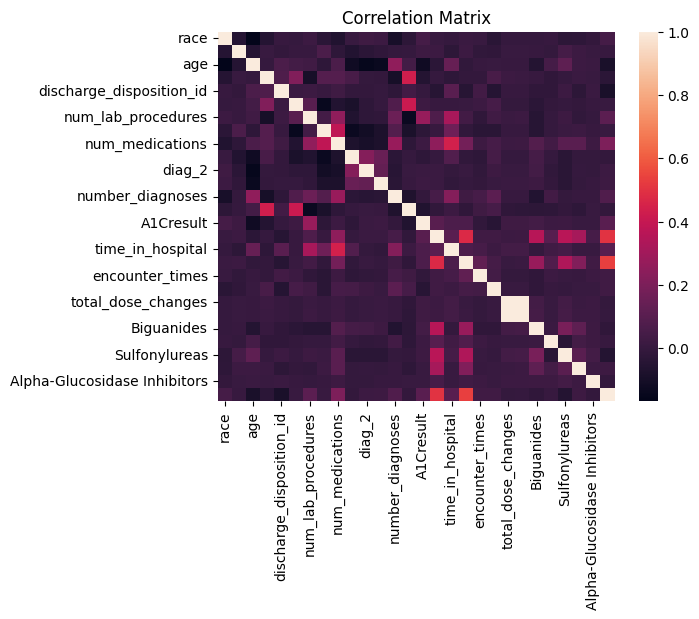

features ned to be removed from correlation ['dose_change_ratio']


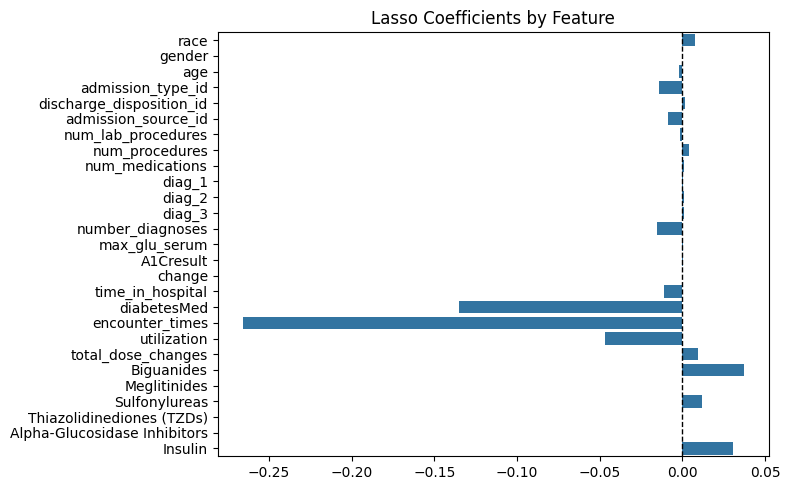

Features to remove based on LASSO: ['gender', 'change', 'Meglitinides', 'Thiazolidinediones (TZDs)', 'Alpha-Glucosidase Inhibitors']


In [19]:
preprocessed_train_df = preprocess_pipeline.fit_transform(df_train)
X_train = preprocessed_train_df.drop(columns=['readmitted'])
y_train = preprocessed_train_df['readmitted']

preprocessed_test_df = preprocess_pipeline.transform(df_test)
X_test = preprocessed_test_df.drop(columns=['readmitted'])
y_test = preprocessed_test_df['readmitted']

In [20]:
y_train.value_counts()


readmitted
2    37942
1    20677
0     5886
Name: count, dtype: int64

In [21]:
# Drop the rows from df_train using the indices
X_test_dropped = X_test.drop(index=indices_predicted_0)
# Reset the index of the resulting dataframe
X_test_dropped = X_test_dropped.reset_index(drop=True)
# Drop the rows from df_test using the indices
y_test_dropped = y_test.drop(index=indices_predicted_0)
# Reset the index of the resulting dataframe
y_test_dropped = y_test_dropped.reset_index(drop=True)

print(X_test_dropped.shape)
print(y_test_dropped.shape)

(8803, 22)
(8803,)


In [22]:
df_train_2class12 = preprocessed_train_df[preprocessed_train_df['readmitted'].isin([1, 2])]
X_train12 = df_train_2class12.drop(columns=['readmitted'])
y_train12 = df_train_2class12['readmitted']
y_train12.value_counts()

readmitted
2    37942
1    20677
Name: count, dtype: int64

In [23]:
classifier12 = RandomForestClassifier(
                n_estimators=100,
                max_depth=30,
                min_samples_split=10,
                min_samples_leaf=5,
                random_state=42,
                class_weight='balanced'
                #class_weight={0:5,1:4}
                )
classifier12.fit(X_train12, y_train12)
predictions12 = classifier12.predict(X_test_dropped)
print("Final Test Classification Report:\n", classification_report(y_test_dropped, predictions12))

# Count the number of predictions for each class
unique, counts = np.unique(predictions12, return_counts=True)
predictions_count = pd.DataFrame({'Class': unique, 'Count': counts})

print(predictions_count)

Final Test Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       842
           1       0.49      0.17      0.25      2896
           2       0.60      0.92      0.73      5065

    accuracy                           0.59      8803
   macro avg       0.36      0.36      0.33      8803
weighted avg       0.51      0.59      0.50      8803

   Class  Count
0      1    998
1      2   7805


now we calculate the overall score for "two models method".

In [24]:
import numpy as np

# Initialize the final prediction array with the same shape as y_test
y_final_pred = np.zeros_like(y_test)

# Step 1: Fill in the predictions from the first model
y_final_pred[indices_predicted_0] = 0  # Set predictions for class "No"

# Step 2: Fill in the predictions from the second model for remaining indices
remaining_indices = np.setdiff1d(np.arange(len(y_test)), indices_predicted_0)
y_final_pred[remaining_indices] = predictions12  # Set predictions for "<30" and ">30"

# Step 3: Print final metrics
from sklearn.metrics import f1_score, recall_score, average_precision_score
F1_score = f1_score(y_test, y_final_pred, average='macro')
recall = recall_score(y_test, y_final_pred, average='macro')
print("Overall F1 Score:", F1_score )
print("Overall Recall:", recall )

Overall F1 Score: 0.3841047227547736
Overall Recall: 0.4079402950163424


In [25]:
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the true labels (One-vs-Rest)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  # Assuming 3 classes
y_final_pred_binarized = label_binarize(y_final_pred, classes=[0, 1, 2])

# Compute PRAUC for each class
prauc_per_class = []
for i in range(y_test_binarized.shape[1]):
    prauc = average_precision_score(y_test_binarized[:, i], y_final_pred_binarized[:, i])
    prauc_per_class.append(prauc)

# Compute macro-average PRAUC
macro_prauc = np.mean(prauc_per_class)

print("PRAUC for each class:", prauc_per_class)
print("Overall Macro-Averaged PRAUC:", macro_prauc)

overall_score = (F1_score + recall + macro_prauc)/3
print("overall score:", overall_score)

PRAUC for each class: [0.13261110531355327, 0.3709217989285538, 0.5944774709847396]
Overall Macro-Averaged PRAUC: 0.3660034584089489
overall score: 0.3860161587266883


FeedBack: In all, using 2 models, we have made 5067 * 0.66 + 588 * 0.23 + 3730 * 0.46 = 5201 correct predictions, the test accuracy is 5201/9385 = 0.55, which is actually lower than using one model. And the overall score is 0.4221, which is lower than "one model method". This is mainly because even though we use the first model to do two class classification, the model still cannot figure out the boundary between class 0 ("No readmission") and class 1("<30 days",">30 days"), where among 5097 samples we only predict 3364 correctly.